# Used Car Fair Market Value Prediction on CarGurus Listing dataset

In [106]:
import pymongo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score, StratifiedKFold, learning_curve, train_test_split
from xgboost import XGBRegressor, plot_tree
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler


## Reading the dataset from the local MongoDB database instance

In [107]:
### Reading the dataset from the local MongoDB database

### Connect to default client
client = pymongo.MongoClient()

### Select the required database
db = client["final_project"]

### Select the required collections
collection = db["cargurus_listings"]
collection2 = db["cargurus_listings_avg_price"]

### Define Cursors
cursor1 = collection.find()
cursor2 = collection2.find()

### Converting the data into list of dictionaries
data_listing = [document for document in cursor1]
data_price = [document for document in cursor2]

In [108]:
### Reading datasets into pandas dataframe
df_listing = pd.DataFrame(data_listing)
df_price = pd.DataFrame(data_price)

In [109]:
### View the dataframe
df_listing

,_id,Make,Model,Year,Trim,Body type,Exterior color,Interior color,Mileage,Condition,...,Back legroom(in),Cargo volume(cubicfeet),Price,Battery capacity(kWh),Battery charge time(120V-hours),Battery range(miles),Cabin size,Bed length(in),Battery charge time(240V-hours),Horsepower (electric)
0,641ce6ba6d3a9786a554bf9b,Honda,CR-V,2016,EX-L FWD,SUV / Crossover,Alabaster Silver Metallic,Black,48208,Used,...,38.0,37.0,22995,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,641ce6ba6d3a9786a554bf9c,Lincoln,Corsair,2020,Reserve FWD,SUV / Crossover,Ingot Silver,Sandstone,23269,Used,...,38.0,34.0,36888,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,641ce6ba6d3a9786a554bf9d,Hyundai,Sonata,2015,Sport FWD,Sedan,Blue,Brown (Beige),86950,Used,...,35.0,16.0,14799,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,641ce6ba6d3a9786a554bf9e,Subaru,Impreza,2018,2.0i Premium Hatchback AWD,Hatchback,White,NaN,30394,Used,...,36.0,20.0,20995,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,641ce6ba6d3a9786a554bf9f,Lexus,NX,2018,300 AWD,SUV / Crossover,Autumn Shimmer,Glazed Caramel,54158,Used,...,36.0,17.0,28311,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,641ce6bb6d3a9786a554c37e,Audi,Q3,2020,quattro Premium Plus S Line 45 TFSI AWD,SUV / Crossover,Glacier White Metallic,Okapi Brown,61046,Used,...,36.0,23.0,28988,NaN,NaN,NaN,NaN,NaN,NaN,NaN
996,641ce6bb6d3a9786a554c37f,Audi,Q5,2022,quattro Premium S Line 45 TFSI AWD,SUV / Crossover,Florett Silver Metallic,Black,6235,Used,...,38.0,25.0,43999,NaN,NaN,NaN,NaN,NaN,NaN,NaN
997,641ce6bb6d3a9786a554c380,Toyota,Tacoma,2022,SR5 V6 Double Cab LB RWD,Pickup Truck,Magnetic Gray Metallic,Cement,18354,Used,...,32.0,NaN,42980,NaN,NaN,NaN,Crew Cab,73.0,NaN,NaN
998,641ce6bb6d3a9786a554c381,Volvo,XC60,2018,T5 Inscription AWD,SUV / Crossover,Crystal White Metallic,Blond,46478,Used,...,38.0,37.0,31888,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [110]:
print(df_listing.shape)
df_listing.info()

(1000, 32)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 32 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   _id                              1000 non-null   object 
 1   Make                             1000 non-null   object 
 2   Model                            1000 non-null   object 
 3   Year                             1000 non-null   int64  
 4   Trim                             982 non-null    object 
 5   Body type                        996 non-null    object 
 6   Exterior color                   992 non-null    object 
 7   Interior color                   914 non-null    object 
 8   Mileage                          1000 non-null   int64  
 9   Condition                        1000 non-null   object 
 10  VIN                              1000 non-null   object 
 11  Fuel type                        986 non-null    object 
 12  Combined g

In [111]:
df_price

,_id,VIN,Average Market Price,Deal,URL
0,641ce6bb6d3a9786a554c383,2HKRM3H78GH544192,22746,Fair Deal,https://www.cargurus.com/Cars/inventorylisting...
1,641ce6bb6d3a9786a554c384,5LMCJ2C93LUL05823,36887,Fair Deal,https://www.cargurus.com/Cars/inventorylisting...
2,641ce6bb6d3a9786a554c385,5NPE34AF0FH090382,14075,Fair Deal,https://www.cargurus.com/Cars/inventorylisting...
3,641ce6bb6d3a9786a554c386,4S3GTAD67J3738274,22309,Good Deal,https://www.cargurus.com/Cars/inventorylisting...
4,641ce6bb6d3a9786a554c387,JTJBARBZ4J2156065,30942,Great Deal,https://www.cargurus.com/Cars/inventorylisting...
...,...,...,...,...,...
995,641ce6bc6d3a9786a554c766,WA1EECF39L1046784,29403,Good Deal,https://www.cargurus.com/Cars/inventorylisting...
996,641ce6bc6d3a9786a554c767,WA1GAAFY8N2088459,43736,Fair Deal,https://www.cargurus.com/Cars/inventorylisting...
997,641ce6bc6d3a9786a554c768,3TMBZ5DNXNM034016,42508,Fair Deal,https://www.cargurus.com/Cars/inventorylisting...
998,641ce6bc6d3a9786a554c769,LYV102RL9JB113561,31320,Fair Deal,https://www.cargurus.com/Cars/inventorylisting...


In [112]:
print(df_price.shape)
df_price.info()

(1000, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   _id                   1000 non-null   object
 1   VIN                   1000 non-null   object
 2   Average Market Price  1000 non-null   int64 
 3   Deal                  1000 non-null   object
 4   URL                   1000 non-null   object
dtypes: int64(1), object(4)
memory usage: 39.2+ KB


## Data Cleaning

In [113]:
### Extracting the subset of Internal Combustion Engine cars, as the electric vehichles cars are usually valued based on totally different features
df_listing_ic = df_listing[df_listing['Fuel type'] != 'Electric']
print(df_listing_ic.shape)

(947, 32)


In [114]:
df_listing_ic['Fuel type'].info()
df_listing_ic['Fuel type'].unique()

<class 'pandas.core.series.Series'>
Int64Index: 947 entries, 0 to 999
Series name: Fuel type
Non-Null Count  Dtype 
--------------  ----- 
933 non-null    object
dtypes: object(1)
memory usage: 14.8+ KB


array(['Gasoline', nan, 'Flex Fuel Vehicle', 'Hybrid', 'Biodiesel',
       'Diesel'], dtype=object)

In [115]:
df_listing_ic[df_listing_ic['Fuel type'].isna()]

,_id,Make,Model,Year,Trim,Body type,Exterior color,Interior color,Mileage,Condition,...,Back legroom(in),Cargo volume(cubicfeet),Price,Battery capacity(kWh),Battery charge time(120V-hours),Battery range(miles),Cabin size,Bed length(in),Battery charge time(240V-hours),Horsepower (electric)
5,641ce6ba6d3a9786a554bfa0,Subaru,Outback,2022,Touring Wagon AWD,Wagon,Magnetite Gray Metallic,NaN,12792,Certified Pre-Owned,...,NaN,NaN,37995,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24,641ce6ba6d3a9786a554bfb3,Subaru,Outback,2022,Touring Wagon AWD,Wagon,Magnetite Gray Metallic,NaN,12792,Certified Pre-Owned,...,NaN,NaN,37995,NaN,NaN,NaN,NaN,NaN,NaN,NaN
148,641ce6ba6d3a9786a554c02f,Subaru,Impreza,2009,2.5i Sport Wagon,Hatchback,NaN,NaN,98375,Used,...,NaN,NaN,8961,NaN,NaN,NaN,NaN,NaN,NaN,NaN
151,641ce6ba6d3a9786a554c032,Subaru,Outback,2022,Touring Wagon AWD,Wagon,Crystal Black,Java,9121,Used,...,NaN,NaN,36981,NaN,NaN,NaN,NaN,NaN,NaN,NaN
160,641ce6ba6d3a9786a554c03b,Subaru,Ascent,2022,Limited AWD,SUV / Crossover,Silver Metallic,Black (Blk Perforated Lth-T),9370,Used,...,NaN,NaN,39981,NaN,NaN,NaN,NaN,NaN,NaN,NaN
162,641ce6ba6d3a9786a554c03d,Subaru,Ascent,2022,Limited AWD,SUV / Crossover,Black / Silver,Black (Blk Perforated Lth-T),9645,Used,...,NaN,NaN,39981,NaN,NaN,NaN,NaN,NaN,NaN,NaN
186,641ce6ba6d3a9786a554c055,Hyundai,Veloster,2013,FWD,Coupe,Ironman Silver Metallic,Black,85347,Used,...,31.0,15.0,11362,NaN,NaN,NaN,NaN,NaN,NaN,NaN
212,641ce6ba6d3a9786a554c06f,Nissan,Sentra,2019,S FWD,Sedan,Blue,Black (Charcoal),55905,Used,...,37.0,15.0,15744,NaN,NaN,NaN,NaN,NaN,NaN,NaN
348,641ce6ba6d3a9786a554c0f7,Nissan,Sentra,2019,S FWD,Sedan,Gray (Gun Metallic),Black (Charcoal),23886,Used,...,37.0,15.0,17988,NaN,NaN,NaN,NaN,NaN,NaN,NaN
518,641ce6bb6d3a9786a554c1a1,Porsche,Panamera,2013,Platinum Edition,Sedan,Black,Black,49870,Used,...,NaN,NaN,32322,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [116]:
### Filling up some values on the fuel type column based on the previous knowledge
df_listing_ic.loc[(df_listing_ic['Model'] == 'Prius') & (df_listing_ic['Fuel type'].isna()), 'Fuel type'] = 'Hybrid'

In [117]:
df_listing_ic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 947 entries, 0 to 999
Data columns (total 32 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   _id                              947 non-null    object 
 1   Make                             947 non-null    object 
 2   Model                            947 non-null    object 
 3   Year                             947 non-null    int64  
 4   Trim                             931 non-null    object 
 5   Body type                        945 non-null    object 
 6   Exterior color                   939 non-null    object 
 7   Interior color                   868 non-null    object 
 8   Mileage                          947 non-null    int64  
 9   Condition                        947 non-null    object 
 10  VIN                              947 non-null    object 
 11  Fuel type                        934 non-null    object 
 12  Combined gas mileage  

In [118]:
df_listing_ic['Fuel type'].fillna('Gasoline', inplace=True)

/var/folders/pf/mk5bhdqj2lj7hnv0k26qwhlr0000gn/T/ipykernel_15682/802677360.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_listing_ic['Fuel type'].fillna('Gasoline', inplace=True)


In [119]:
df_listing_ic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 947 entries, 0 to 999
Data columns (total 32 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   _id                              947 non-null    object 
 1   Make                             947 non-null    object 
 2   Model                            947 non-null    object 
 3   Year                             947 non-null    int64  
 4   Trim                             931 non-null    object 
 5   Body type                        945 non-null    object 
 6   Exterior color                   939 non-null    object 
 7   Interior color                   868 non-null    object 
 8   Mileage                          947 non-null    int64  
 9   Condition                        947 non-null    object 
 10  VIN                              947 non-null    object 
 11  Fuel type                        947 non-null    object 
 12  Combined gas mileage  

In [120]:
### Dropping unnecessary columns, the ones that are related to electric cars, or won't affect the car's price much
df_listing_ic = df_listing_ic.drop(columns=['Horsepower (electric)', 'Battery charge time(240V-hours)', 'Bed length(in)', 'Cabin size', 'Battery range(miles)', 'Battery charge time(120V-hours)', 'Battery capacity(kWh)', 'Cargo volume(cubicfeet)','Trim', '_id'])

In [121]:
df_listing_ic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 947 entries, 0 to 999
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Make                  947 non-null    object 
 1   Model                 947 non-null    object 
 2   Year                  947 non-null    int64  
 3   Body type             945 non-null    object 
 4   Exterior color        939 non-null    object 
 5   Interior color        868 non-null    object 
 6   Mileage               947 non-null    int64  
 7   Condition             947 non-null    object 
 8   VIN                   947 non-null    object 
 9   Fuel type             947 non-null    object 
 10  Combined gas mileage  779 non-null    float64
 11  City gas mileage      779 non-null    float64
 12  Highway gas mileage   779 non-null    float64
 13  Fuel tank size(gal)   922 non-null    float64
 14  Transmission          926 non-null    object 
 15  Drivetrain            9

In [122]:
print(df_listing_ic['Body type'].unique())
df_listing_ic[df_listing_ic['Body type'].isna()]

['SUV / Crossover' 'Sedan' 'Hatchback' 'Wagon' 'Pickup Truck' 'Coupe'
 'Van' 'Minivan' 'Convertible' nan]


,Make,Model,Year,Body type,Exterior color,Interior color,Mileage,Condition,VIN,Fuel type,...,Highway gas mileage,Fuel tank size(gal),Transmission,Drivetrain,Engine Size(Liter),Horsepower,Doors,Front legroom(in),Back legroom(in),Price
407,Honda,Civic Hybrid,2008,NaN,Gray,Black,138100,Used,JHMFA362X8S009644,Hybrid,...,NaN,NaN,Continuously Variable Transmission,NaN,1.3,110.0,NaN,NaN,NaN,8999
438,Toyota,C-HR,2021,NaN,Magnetic Gray Metallic,Black,22343,Used,JTNKHMBX2M1112894,Gasoline,...,NaN,NaN,Automatic,NaN,2.0,144.0,NaN,NaN,NaN,25842


In [123]:
### Filling up the missing body type values
df_listing_ic.loc[(df_listing_ic['VIN'] == 'JHMFA362X8S009644') & (df_listing_ic['Body type'].isna()), 'Body type'] = 'Sedan'
df_listing_ic.loc[(df_listing_ic['VIN'] == 'JTNKHMBX2M1112894') & (df_listing_ic['Body type'].isna()), 'Body type'] = 'SUV / Crossover'


In [124]:
df_listing_ic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 947 entries, 0 to 999
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Make                  947 non-null    object 
 1   Model                 947 non-null    object 
 2   Year                  947 non-null    int64  
 3   Body type             947 non-null    object 
 4   Exterior color        939 non-null    object 
 5   Interior color        868 non-null    object 
 6   Mileage               947 non-null    int64  
 7   Condition             947 non-null    object 
 8   VIN                   947 non-null    object 
 9   Fuel type             947 non-null    object 
 10  Combined gas mileage  779 non-null    float64
 11  City gas mileage      779 non-null    float64
 12  Highway gas mileage   779 non-null    float64
 13  Fuel tank size(gal)   922 non-null    float64
 14  Transmission          926 non-null    object 
 15  Drivetrain            9

In [125]:
df_listing_ic[df_listing_ic['Engine Size(Liter)'].isna()]

,Make,Model,Year,Body type,Exterior color,Interior color,Mileage,Condition,VIN,Fuel type,...,Highway gas mileage,Fuel tank size(gal),Transmission,Drivetrain,Engine Size(Liter),Horsepower,Doors,Front legroom(in),Back legroom(in),Price
5,Subaru,Outback,2022,Wagon,Magnetite Gray Metallic,NaN,12792,Certified Pre-Owned,4S4BTAPC4N3138597,Gasoline,...,NaN,NaN,Automatic,NaN,NaN,NaN,NaN,NaN,NaN,37995
24,Subaru,Outback,2022,Wagon,Magnetite Gray Metallic,NaN,12792,Certified Pre-Owned,4S4BTAPC4N3138597,Gasoline,...,NaN,NaN,Automatic,NaN,NaN,NaN,NaN,NaN,NaN,37995
148,Subaru,Impreza,2009,Hatchback,NaN,NaN,98375,Used,JF1GH61669G813950,Gasoline,...,NaN,NaN,5-Speed Manual Overdrive,NaN,NaN,NaN,NaN,NaN,NaN,8961
151,Subaru,Outback,2022,Wagon,Crystal Black,Java,9121,Used,4S4BTAPC8N3208683,Gasoline,...,NaN,NaN,Continuously Variable Transmission,NaN,NaN,NaN,NaN,NaN,NaN,36981
160,Subaru,Ascent,2022,SUV / Crossover,Silver Metallic,Black (Blk Perforated Lth-T),9370,Used,4S4WMALDXN3429425,Gasoline,...,NaN,NaN,Continuously Variable Transmission,NaN,NaN,NaN,NaN,NaN,NaN,39981
162,Subaru,Ascent,2022,SUV / Crossover,Black / Silver,Black (Blk Perforated Lth-T),9645,Used,4S4WMALD5N3433754,Gasoline,...,NaN,NaN,Continuously Variable Transmission,NaN,NaN,NaN,NaN,NaN,NaN,39981
186,Hyundai,Veloster,2013,Coupe,Ironman Silver Metallic,Black,85347,Used,KMHTC6ADXDU174614,Gasoline,...,NaN,13.0,6-Speed Dual Clutch,Front-Wheel Drive,NaN,NaN,3.0,43.0,31.0,11362
212,Nissan,Sentra,2019,Sedan,Blue,Black (Charcoal),55905,Used,3N1AB7AP4KY384279,Gasoline,...,NaN,13.0,Continuously Variable Transmission,Front-Wheel Drive,NaN,NaN,4.0,42.0,37.0,15744
340,Toyota,Mirai,2022,Sedan,Oxygen White,Black,15249,Certified Pre-Owned,JTDAAAAAXNA005612,Gasoline,...,NaN,37.0,1-Speed Automatic,Rear-Wheel Drive,NaN,NaN,4.0,42.0,33.0,26699
345,Toyota,Mirai,2022,Sedan,Supersonic Red,Black,14438,Certified Pre-Owned,JTDAAAAA2NA006009,Gasoline,...,NaN,37.0,1-Speed Automatic,Rear-Wheel Drive,NaN,NaN,4.0,42.0,33.0,26999


In [126]:
### Dropping unnecessary columns, the ones that are related to electric cars, or won't affect the car's price much
df_listing_ic = df_listing_ic.drop(columns=['City gas mileage','Highway gas mileage', 'Interior color'])

In [127]:
df_listing_ic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 947 entries, 0 to 999
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Make                  947 non-null    object 
 1   Model                 947 non-null    object 
 2   Year                  947 non-null    int64  
 3   Body type             947 non-null    object 
 4   Exterior color        939 non-null    object 
 5   Mileage               947 non-null    int64  
 6   Condition             947 non-null    object 
 7   VIN                   947 non-null    object 
 8   Fuel type             947 non-null    object 
 9   Combined gas mileage  779 non-null    float64
 10  Fuel tank size(gal)   922 non-null    float64
 11  Transmission          926 non-null    object 
 12  Drivetrain            923 non-null    object 
 13  Engine Size(Liter)    929 non-null    float64
 14  Horsepower            764 non-null    float64
 15  Doors                 9

In [128]:
print(df_listing_ic['Doors'].unique())
print(df_listing_ic['Body type'].unique())


[ 4. nan  2.  3.]
['SUV / Crossover' 'Sedan' 'Hatchback' 'Wagon' 'Pickup Truck' 'Coupe'
 'Van' 'Minivan' 'Convertible']


In [129]:
df_listing_ic

,Make,Model,Year,Body type,Exterior color,Mileage,Condition,VIN,Fuel type,Combined gas mileage,Fuel tank size(gal),Transmission,Drivetrain,Engine Size(Liter),Horsepower,Doors,Front legroom(in),Back legroom(in),Price
0,Honda,CR-V,2016,SUV / Crossover,Alabaster Silver Metallic,48208,Used,2HKRM3H78GH544192,Gasoline,29.0,15.0,Continuously Variable Transmission,Front-Wheel Drive,2.4,185.0,4.0,41.0,38.0,22995
1,Lincoln,Corsair,2020,SUV / Crossover,Ingot Silver,23269,Used,5LMCJ2C93LUL05823,Gasoline,25.0,16.0,8-Speed Automatic,Front-Wheel Drive,2.0,250.0,4.0,43.0,38.0,36888
2,Hyundai,Sonata,2015,Sedan,Blue,86950,Used,5NPE34AF0FH090382,Gasoline,28.0,18.0,6-Speed Automatic,Front-Wheel Drive,2.4,185.0,4.0,45.0,35.0,14799
3,Subaru,Impreza,2018,Hatchback,White,30394,Used,4S3GTAD67J3738274,Gasoline,32.0,13.0,Automatic,All-Wheel Drive,2.0,152.0,4.0,43.0,36.0,20995
4,Lexus,NX,2018,SUV / Crossover,Autumn Shimmer,54158,Used,JTJBARBZ4J2156065,Gasoline,24.0,15.0,6-Speed Automatic,All-Wheel Drive,2.0,235.0,4.0,42.0,36.0,28311
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,Audi,Q3,2020,SUV / Crossover,Glacier White Metallic,61046,Used,WA1EECF39L1046784,Gasoline,22.0,15.0,8-Speed Automatic,All-Wheel Drive,2.0,228.0,4.0,40.0,36.0,28988
996,Audi,Q5,2022,SUV / Crossover,Florett Silver Metallic,6235,Used,WA1GAAFY8N2088459,Gasoline,NaN,18.0,7-Speed Automatic,All-Wheel Drive,2.0,261.0,4.0,40.0,38.0,43999
997,Toyota,Tacoma,2022,Pickup Truck,Magnetic Gray Metallic,18354,Used,3TMBZ5DNXNM034016,Gasoline,21.0,21.0,6-Speed Automatic,4X2,3.5,278.0,4.0,42.0,32.0,42980
998,Volvo,XC60,2018,SUV / Crossover,Crystal White Metallic,46478,Used,LYV102RL9JB113561,Gasoline,23.0,18.0,Automatic,All-Wheel Drive,2.0,250.0,4.0,41.0,38.0,31888


In [130]:
df_listing_ic.loc[(df_listing_ic['Body type'] == 'Coupe') & (df_listing_ic['Doors'].isna()), 'Doors'] = 2.0

In [131]:
df_listing_ic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 947 entries, 0 to 999
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Make                  947 non-null    object 
 1   Model                 947 non-null    object 
 2   Year                  947 non-null    int64  
 3   Body type             947 non-null    object 
 4   Exterior color        939 non-null    object 
 5   Mileage               947 non-null    int64  
 6   Condition             947 non-null    object 
 7   VIN                   947 non-null    object 
 8   Fuel type             947 non-null    object 
 9   Combined gas mileage  779 non-null    float64
 10  Fuel tank size(gal)   922 non-null    float64
 11  Transmission          926 non-null    object 
 12  Drivetrain            923 non-null    object 
 13  Engine Size(Liter)    929 non-null    float64
 14  Horsepower            764 non-null    float64
 15  Doors                 9

In [132]:
### Filling up the missing door values
df_listing_ic['Doors'].fillna(4.0, inplace=True)
df_listing_ic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 947 entries, 0 to 999
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Make                  947 non-null    object 
 1   Model                 947 non-null    object 
 2   Year                  947 non-null    int64  
 3   Body type             947 non-null    object 
 4   Exterior color        939 non-null    object 
 5   Mileage               947 non-null    int64  
 6   Condition             947 non-null    object 
 7   VIN                   947 non-null    object 
 8   Fuel type             947 non-null    object 
 9   Combined gas mileage  779 non-null    float64
 10  Fuel tank size(gal)   922 non-null    float64
 11  Transmission          926 non-null    object 
 12  Drivetrain            923 non-null    object 
 13  Engine Size(Liter)    929 non-null    float64
 14  Horsepower            764 non-null    float64
 15  Doors                 9

In [133]:
### Drop Columns where drivetrain is NAN
df_listing_ic = df_listing_ic.dropna(subset=['Drivetrain'])
df_listing_ic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 923 entries, 0 to 999
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Make                  923 non-null    object 
 1   Model                 923 non-null    object 
 2   Year                  923 non-null    int64  
 3   Body type             923 non-null    object 
 4   Exterior color        916 non-null    object 
 5   Mileage               923 non-null    int64  
 6   Condition             923 non-null    object 
 7   VIN                   923 non-null    object 
 8   Fuel type             923 non-null    object 
 9   Combined gas mileage  779 non-null    float64
 10  Fuel tank size(gal)   922 non-null    float64
 11  Transmission          904 non-null    object 
 12  Drivetrain            923 non-null    object 
 13  Engine Size(Liter)    913 non-null    float64
 14  Horsepower            750 non-null    float64
 15  Doors                 9

In [134]:
### Filling up the missing color values with the most frequent color
mode_color = df_listing_ic['Exterior color'].mode().iloc[0]
df_listing_ic['Exterior color'].fillna(mode_color, inplace=True)
df_listing_ic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 923 entries, 0 to 999
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Make                  923 non-null    object 
 1   Model                 923 non-null    object 
 2   Year                  923 non-null    int64  
 3   Body type             923 non-null    object 
 4   Exterior color        923 non-null    object 
 5   Mileage               923 non-null    int64  
 6   Condition             923 non-null    object 
 7   VIN                   923 non-null    object 
 8   Fuel type             923 non-null    object 
 9   Combined gas mileage  779 non-null    float64
 10  Fuel tank size(gal)   922 non-null    float64
 11  Transmission          904 non-null    object 
 12  Drivetrain            923 non-null    object 
 13  Engine Size(Liter)    913 non-null    float64
 14  Horsepower            750 non-null    float64
 15  Doors                 9

/var/folders/pf/mk5bhdqj2lj7hnv0k26qwhlr0000gn/T/ipykernel_15682/138041055.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_listing_ic['Exterior color'].fillna(mode_color, inplace=True)


In [135]:
df_listing_ic['Transmission'].fillna("Automatic", inplace=True)
df_listing_ic['Transmission'].unique()

/var/folders/pf/mk5bhdqj2lj7hnv0k26qwhlr0000gn/T/ipykernel_15682/1822219557.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_listing_ic['Transmission'].fillna("Automatic", inplace=True)


array(['Continuously Variable Transmission', '8-Speed Automatic',
       '6-Speed Automatic', 'Automatic', 'Manual',
       '6-Speed Automatic Overdrive', '9-Speed Automatic',
       '9-Speed Automatic Overdrive', '7-Speed Dual Clutch',
       '6-Speed Dual Clutch', '7-Speed Automatic',
       '5-Speed Automatic Overdrive', '6-Speed Manual',
       '5-Speed Automatic', '5-Speed Manual', '1-Speed Automatic',
       '4-Speed Automatic Overdrive', '4-Speed Automatic',
       '1-Speed Dual Clutch', '8-Speed Automatic Overdrive',
       '5-Speed Manual Overdrive', '8-Speed Manual',
       '6-Speed Manual Overdrive'], dtype=object)

In [136]:
### Replacing all different automaic and manual transmission values with just "Automatic" or "Manual"
df_listing_ic.loc[df_listing_ic['Transmission'].str.contains('Automatic'), 'Transmission'] = 'Automatic'
df_listing_ic.loc[df_listing_ic['Transmission'].str.contains('Manual'), 'Transmission'] = 'Manual'
df_listing_ic.loc[df_listing_ic['Transmission'].str.contains('Dual Clutch'), 'Transmission'] = 'Dual Clutch'

df_listing_ic['Transmission'].unique()


array(['Continuously Variable Transmission', 'Automatic', 'Manual',
       'Dual Clutch'], dtype=object)

In [137]:
df_listing_ic[df_listing_ic["Engine Size(Liter)"].isna()]

,Make,Model,Year,Body type,Exterior color,Mileage,Condition,VIN,Fuel type,Combined gas mileage,Fuel tank size(gal),Transmission,Drivetrain,Engine Size(Liter),Horsepower,Doors,Front legroom(in),Back legroom(in),Price
186,Hyundai,Veloster,2013,Coupe,Ironman Silver Metallic,85347,Used,KMHTC6ADXDU174614,Gasoline,NaN,13.0,Dual Clutch,Front-Wheel Drive,NaN,NaN,3.0,43.0,31.0,11362
212,Nissan,Sentra,2019,Sedan,Blue,55905,Used,3N1AB7AP4KY384279,Gasoline,NaN,13.0,Continuously Variable Transmission,Front-Wheel Drive,NaN,NaN,4.0,42.0,37.0,15744
340,Toyota,Mirai,2022,Sedan,Oxygen White,15249,Certified Pre-Owned,JTDAAAAAXNA005612,Gasoline,NaN,37.0,Automatic,Rear-Wheel Drive,NaN,NaN,4.0,42.0,33.0,26699
345,Toyota,Mirai,2022,Sedan,Supersonic Red,14438,Certified Pre-Owned,JTDAAAAA2NA006009,Gasoline,NaN,37.0,Automatic,Rear-Wheel Drive,NaN,NaN,4.0,42.0,33.0,26999
348,Nissan,Sentra,2019,Sedan,Gray (Gun Metallic),23886,Used,3N1AB7AP2KY297383,Gasoline,NaN,13.0,Continuously Variable Transmission,Front-Wheel Drive,NaN,NaN,4.0,42.0,37.0,17988
368,Toyota,Mirai,2019,Sedan,Salsa Red Pearl,12733,Certified Pre-Owned,JTDBVRBD9KA007671,Gasoline,NaN,32.0,Automatic,Front-Wheel Drive,NaN,NaN,4.0,42.0,30.0,18888
601,Toyota,Prius,2010,Hatchback,Winter Gray Metallic,123121,Used,JTDKN3DU5A0179419,Hybrid,NaN,11.0,Automatic,Front-Wheel Drive,NaN,NaN,4.0,42.0,36.0,11499
804,Nissan,350Z,2006,Convertible,Redline,118974,Used,JN1AZ36A36M456364,Gasoline,NaN,20.0,Automatic,Rear-Wheel Drive,NaN,NaN,2.0,42.0,NaN,11782
914,Hyundai,Nexo,2019,SUV / Crossover,Cocoon Silver,15976,Used,KM8J84A68KU002562,Gasoline,NaN,NaN,Automatic,Front-Wheel Drive,NaN,NaN,4.0,41.0,38.0,16999
930,Audi,S7,2020,Sedan,Gray,29378,Used,WAUSFAF27LN034222,Gasoline,NaN,19.0,Automatic,All-Wheel Drive,NaN,NaN,4.0,41.0,37.0,71998


In [138]:
df_listing_ic = df_listing_ic.dropna(subset=["Engine Size(Liter)"])
df_listing_ic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 913 entries, 0 to 999
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Make                  913 non-null    object 
 1   Model                 913 non-null    object 
 2   Year                  913 non-null    int64  
 3   Body type             913 non-null    object 
 4   Exterior color        913 non-null    object 
 5   Mileage               913 non-null    int64  
 6   Condition             913 non-null    object 
 7   VIN                   913 non-null    object 
 8   Fuel type             913 non-null    object 
 9   Combined gas mileage  779 non-null    float64
 10  Fuel tank size(gal)   913 non-null    float64
 11  Transmission          913 non-null    object 
 12  Drivetrain            913 non-null    object 
 13  Engine Size(Liter)    913 non-null    float64
 14  Horsepower            750 non-null    float64
 15  Doors                 9

In [139]:
df_listing_ic = df_listing_ic.dropna(subset=["Front legroom(in)"])
df_listing_ic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 892 entries, 0 to 999
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Make                  892 non-null    object 
 1   Model                 892 non-null    object 
 2   Year                  892 non-null    int64  
 3   Body type             892 non-null    object 
 4   Exterior color        892 non-null    object 
 5   Mileage               892 non-null    int64  
 6   Condition             892 non-null    object 
 7   VIN                   892 non-null    object 
 8   Fuel type             892 non-null    object 
 9   Combined gas mileage  764 non-null    float64
 10  Fuel tank size(gal)   892 non-null    float64
 11  Transmission          892 non-null    object 
 12  Drivetrain            892 non-null    object 
 13  Engine Size(Liter)    892 non-null    float64
 14  Horsepower            729 non-null    float64
 15  Doors                 8

In [140]:
df_listing_ic = df_listing_ic.dropna(subset=["Back legroom(in)"])
df_listing_ic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 853 entries, 0 to 999
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Make                  853 non-null    object 
 1   Model                 853 non-null    object 
 2   Year                  853 non-null    int64  
 3   Body type             853 non-null    object 
 4   Exterior color        853 non-null    object 
 5   Mileage               853 non-null    int64  
 6   Condition             853 non-null    object 
 7   VIN                   853 non-null    object 
 8   Fuel type             853 non-null    object 
 9   Combined gas mileage  747 non-null    float64
 10  Fuel tank size(gal)   853 non-null    float64
 11  Transmission          853 non-null    object 
 12  Drivetrain            853 non-null    object 
 13  Engine Size(Liter)    853 non-null    float64
 14  Horsepower            698 non-null    float64
 15  Doors                 8

In [141]:
### Identify columns with missing values, and columns that do not have missing values
columns_with_missing_values = df_listing_ic.columns[df_listing_ic.isna().any()].tolist()
print(columns_with_missing_values)

columns_without_na = [col for col in df_listing_ic.columns if col not in columns_with_missing_values]
print(columns_without_na)

columns_without_na.remove('VIN')
columns_without_na.remove('Price')

['Combined gas mileage', 'Horsepower']
['Make', 'Model', 'Year', 'Body type', 'Exterior color', 'Mileage', 'Condition', 'VIN', 'Fuel type', 'Fuel tank size(gal)', 'Transmission', 'Drivetrain', 'Engine Size(Liter)', 'Doors', 'Front legroom(in)', 'Back legroom(in)', 'Price']


In [142]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge

In [143]:
### Columns that we will use to predict the missing values from the ['Combined gas mileage', 'Horsepower'] columns
predictor_vars = ['Engine Size(Liter)', 'Front legroom(in)', 'Back legroom(in)', 'Price', 'Fuel tank size(gal)']

In [144]:
### We will use regression imputation to fill up the missing values of the specified columns

# fit regression model using Bayesian Ridge
imputer = IterativeImputer(estimator=BayesianRidge())

# impute missing values
imputed_data = imputer.fit_transform(df_listing_ic[predictor_vars + columns_with_missing_values])

# substitute imputed values for missing values
df_listing_ic[columns_with_missing_values] = imputed_data[:, -len(columns_with_missing_values):]

print(df_listing_ic)

        Make    Model  Year        Body type             Exterior color  \
0      Honda     CR-V  2016  SUV / Crossover  Alabaster Silver Metallic   
1    Lincoln  Corsair  2020  SUV / Crossover               Ingot Silver   
2    Hyundai   Sonata  2015            Sedan                       Blue   
3     Subaru  Impreza  2018        Hatchback                      White   
4      Lexus       NX  2018  SUV / Crossover             Autumn Shimmer   
..       ...      ...   ...              ...                        ...   
995     Audi       Q3  2020  SUV / Crossover     Glacier White Metallic   
996     Audi       Q5  2022  SUV / Crossover    Florett Silver Metallic   
997   Toyota   Tacoma  2022     Pickup Truck     Magnetic Gray Metallic   
998    Volvo     XC60  2018  SUV / Crossover     Crystal White Metallic   
999     Audi       A6  2019            Sedan      Mythos Black Metallic   

     Mileage Condition                VIN Fuel type  Combined gas mileage  \
0      48208      Used

In [145]:
df_listing_ic

,Make,Model,Year,Body type,Exterior color,Mileage,Condition,VIN,Fuel type,Combined gas mileage,Fuel tank size(gal),Transmission,Drivetrain,Engine Size(Liter),Horsepower,Doors,Front legroom(in),Back legroom(in),Price
0,Honda,CR-V,2016,SUV / Crossover,Alabaster Silver Metallic,48208,Used,2HKRM3H78GH544192,Gasoline,29.000000,15.0,Continuously Variable Transmission,Front-Wheel Drive,2.4,185.0,4.0,41.0,38.0,22995
1,Lincoln,Corsair,2020,SUV / Crossover,Ingot Silver,23269,Used,5LMCJ2C93LUL05823,Gasoline,25.000000,16.0,Automatic,Front-Wheel Drive,2.0,250.0,4.0,43.0,38.0,36888
2,Hyundai,Sonata,2015,Sedan,Blue,86950,Used,5NPE34AF0FH090382,Gasoline,28.000000,18.0,Automatic,Front-Wheel Drive,2.4,185.0,4.0,45.0,35.0,14799
3,Subaru,Impreza,2018,Hatchback,White,30394,Used,4S3GTAD67J3738274,Gasoline,32.000000,13.0,Automatic,All-Wheel Drive,2.0,152.0,4.0,43.0,36.0,20995
4,Lexus,NX,2018,SUV / Crossover,Autumn Shimmer,54158,Used,JTJBARBZ4J2156065,Gasoline,24.000000,15.0,Automatic,All-Wheel Drive,2.0,235.0,4.0,42.0,36.0,28311
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,Audi,Q3,2020,SUV / Crossover,Glacier White Metallic,61046,Used,WA1EECF39L1046784,Gasoline,22.000000,15.0,Automatic,All-Wheel Drive,2.0,228.0,4.0,40.0,36.0,28988
996,Audi,Q5,2022,SUV / Crossover,Florett Silver Metallic,6235,Used,WA1GAAFY8N2088459,Gasoline,25.311217,18.0,Automatic,All-Wheel Drive,2.0,261.0,4.0,40.0,38.0,43999
997,Toyota,Tacoma,2022,Pickup Truck,Magnetic Gray Metallic,18354,Used,3TMBZ5DNXNM034016,Gasoline,21.000000,21.0,Automatic,4X2,3.5,278.0,4.0,42.0,32.0,42980
998,Volvo,XC60,2018,SUV / Crossover,Crystal White Metallic,46478,Used,LYV102RL9JB113561,Gasoline,23.000000,18.0,Automatic,All-Wheel Drive,2.0,250.0,4.0,41.0,38.0,31888


In [146]:
df_listing_ic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 853 entries, 0 to 999
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Make                  853 non-null    object 
 1   Model                 853 non-null    object 
 2   Year                  853 non-null    int64  
 3   Body type             853 non-null    object 
 4   Exterior color        853 non-null    object 
 5   Mileage               853 non-null    int64  
 6   Condition             853 non-null    object 
 7   VIN                   853 non-null    object 
 8   Fuel type             853 non-null    object 
 9   Combined gas mileage  853 non-null    float64
 10  Fuel tank size(gal)   853 non-null    float64
 11  Transmission          853 non-null    object 
 12  Drivetrain            853 non-null    object 
 13  Engine Size(Liter)    853 non-null    float64
 14  Horsepower            853 non-null    float64
 15  Doors                 8

In [147]:
### Now we will be joining the avg price dataset we have, with the listing dataset. In the model building stage, we will
df_price_y = df_price.loc[:, ['VIN','Average Market Price']]

In [148]:
df_price_y = df_price_y.drop_duplicates(subset='VIN', keep='first')
df_price_y.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 967 entries, 0 to 999
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   VIN                   967 non-null    object
 1   Average Market Price  967 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 22.7+ KB


In [181]:
df_full = pd.merge(df_listing_ic, df_price_y, on='VIN', how='inner')

In [182]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 853 entries, 0 to 852
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Make                  853 non-null    object 
 1   Model                 853 non-null    object 
 2   Year                  853 non-null    int64  
 3   Body type             853 non-null    object 
 4   Exterior color        853 non-null    object 
 5   Mileage               853 non-null    int64  
 6   Condition             853 non-null    object 
 7   VIN                   853 non-null    object 
 8   Fuel type             853 non-null    object 
 9   Combined gas mileage  853 non-null    float64
 10  Fuel tank size(gal)   853 non-null    float64
 11  Transmission          853 non-null    object 
 12  Drivetrain            853 non-null    object 
 13  Engine Size(Liter)    853 non-null    float64
 14  Horsepower            853 non-null    float64
 15  Doors                 8

## Exploratory Data Analysis

Text(0.5, 1.0, 'Horsepower vs. Avg Market Price')

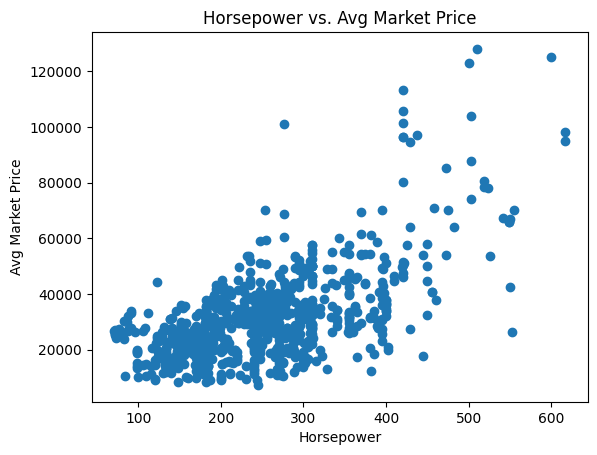

In [47]:
### Scatter Plot of Horsepower vs Price
plt.scatter(df_full['Horsepower'], df_full['Average Market Price'])

plt.xlabel("Horsepower")
plt.ylabel('Avg Market Price')
plt.title('Horsepower vs. Avg Market Price')

It seems like as the horsepower increases, the price of the car increases too

In [174]:
### Let's check the correlation between those 2 columns
correlation = df_full['Average Market Price'].corr(df_full['Horsepower'])

print(f"Correlation between 'Avg Market Price' and 'Horsepower': {correlation}")

Correlation between 'Avg Market Price' and 'Horsepower': 0.6277326109069411


Text(0.5, 1.0, 'Combined gas mileage vs. Avg Market Price')

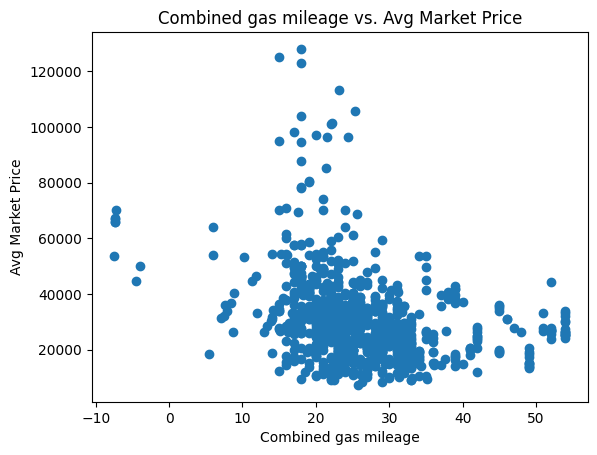

In [175]:
### Scatter Plot of Combined Gas Mileage vs Price
plt.scatter(df_full['Combined gas mileage'], df_full['Average Market Price'])

plt.xlabel("Combined gas mileage")
plt.ylabel('Avg Market Price')
plt.title('Combined gas mileage vs. Avg Market Price')

It seems like there is negative linear relationship between the price and Combined Gas Mileage, which makes sense, as the "Gas Saver" cars with high gas mileage tend to cost less than their more expensive and more powerfull counterparts

In [176]:
### Let's check the correlation between those 2 columns
correlation = df_full['Average Market Price'].corr(df_full['Combined gas mileage'])

print(f"Correlation between 'Avg Market Price' and 'Combined gas mileage': {correlation}")

Correlation between 'Avg Market Price' and 'Combined gas mileage': -0.3421783634140608


Text(0.5, 1.0, 'Mileage vs. Avg Market Price')

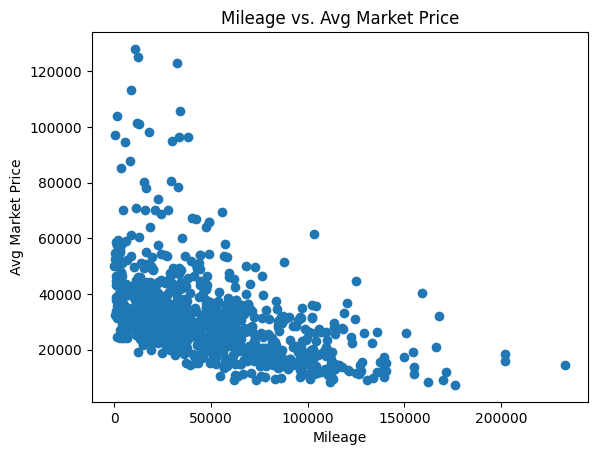

In [177]:
### Scatter Plot of Mileage vs Price
plt.scatter(df_full['Mileage'], df_full['Average Market Price'])

plt.xlabel("Mileage")
plt.ylabel('Avg Market Price')
plt.title('Mileage vs. Avg Market Price')

It seems like as the mileage of the car increases, it starts to cost less and less, which makes perfect sense

In [178]:
correlation = df_full['Average Market Price'].corr(df_full['Mileage'])

print(f"Correlation between 'Avg Market Price' and 'Mileage': {correlation}")

Correlation between 'Avg Market Price' and 'Mileage': -0.4874531266218752


Correlation between 'Avg Market Price' and 'Engine Size(Liter)': 0.4264429569077985


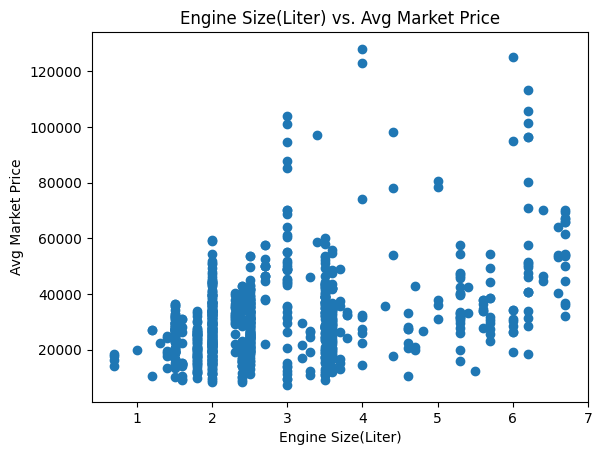

In [179]:
### Scatter Plot of Engine Size vs Price
plt.scatter(df_full['Engine Size(Liter)'], df_full['Average Market Price'])

plt.xlabel("Engine Size(Liter)")
plt.ylabel('Avg Market Price')
plt.title('Engine Size(Liter) vs. Avg Market Price')


correlation = df_full['Average Market Price'].corr(df_full['Engine Size(Liter)'])

print(f"Correlation between 'Avg Market Price' and 'Engine Size(Liter)': {correlation}")

Correlation between 'Avg Market Price' and 'Front legroom(in)': 0.027755854245348315


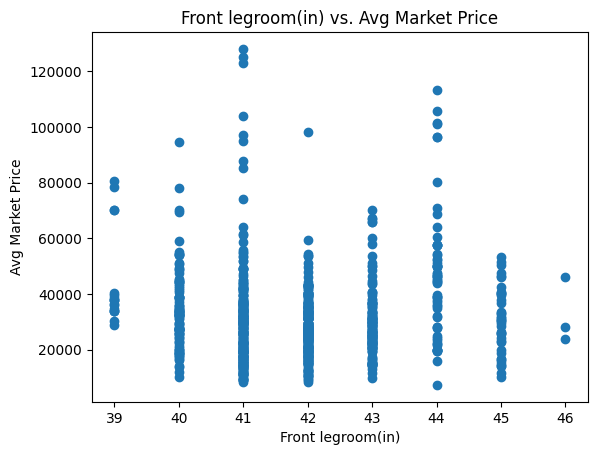

In [180]:
### Scatter Plot of Front Leg Room vs Price
plt.scatter(df_full['Front legroom(in)'], df_full['Average Market Price'])

plt.xlabel("Front legroom(in)")
plt.ylabel('Avg Market Price')
plt.title('Front legroom(in) vs. Avg Market Price')


correlation = df_full['Average Market Price'].corr(df_full['Front legroom(in)'])

print(f"Correlation between 'Avg Market Price' and 'Front legroom(in)': {correlation}")

It seems like front legroom and price are not really related with each other.

Correlation between 'Avg Market Price' and 'Year': 0.5114359444051045


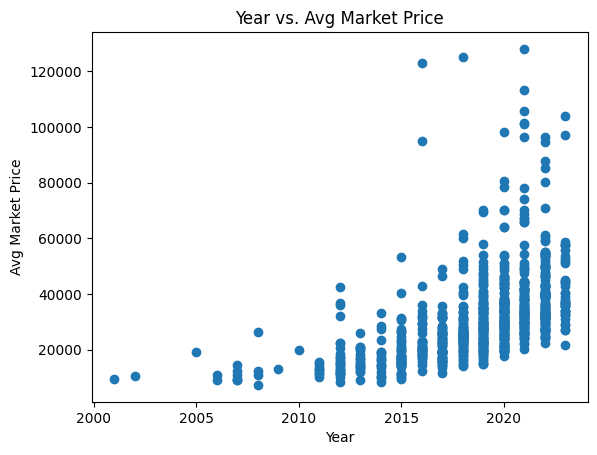

In [181]:
### Scatter Plot of Year vs Price
plt.scatter(df_full['Year'], df_full['Average Market Price'])

plt.xlabel("Year")
plt.ylabel('Avg Market Price')
plt.title('Year vs. Avg Market Price')


correlation = df_full['Average Market Price'].corr(df_full['Year'])

print(f"Correlation between 'Avg Market Price' and 'Year': {correlation}")

As we might have guessed, newer cars tend to cost more

Now, let's take a look at some boxplots of price by some categorical variables

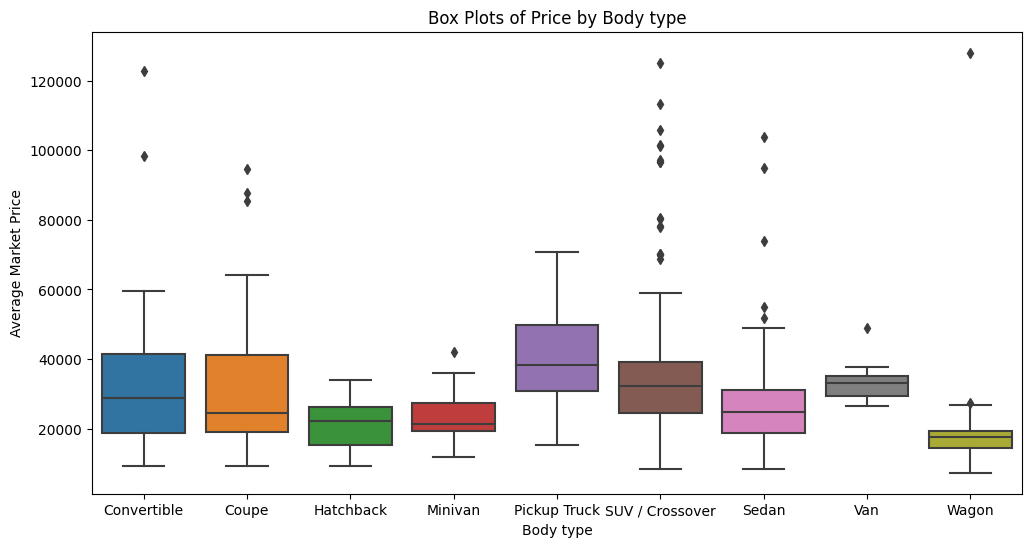

In [186]:
### Boxplots of Price by body type

plt.figure(figsize=(12, 6))

sns.boxplot(x = 'Body type', y='Average Market Price', data= df_full )

plt.xlabel('Body type')
plt.ylabel('Average Market Price')
plt.title('Box Plots of Price by Body type')

plt.show()

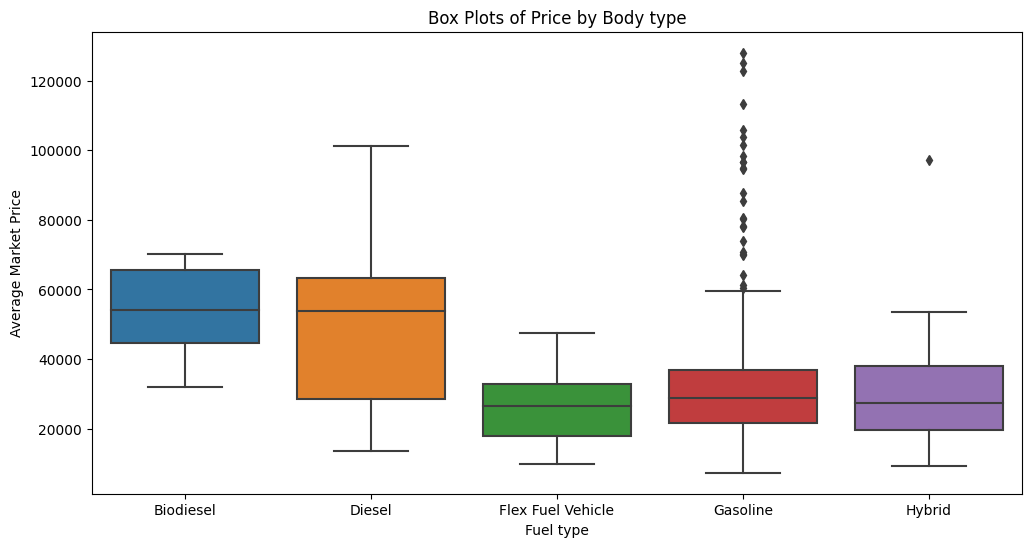

In [187]:
### Boxplots of Price by Fuel type

plt.figure(figsize=(12, 6))

sns.boxplot(x = 'Fuel type', y='Average Market Price', data= df_full )

plt.xlabel('Fuel type')
plt.ylabel('Average Market Price')
plt.title('Box Plots of Price by Body type')

plt.show()

It seems like diesel fueled vehicles tend to cost more in the used car market

Text(0.5, 1.0, 'Box Plots of Price by Transmission')

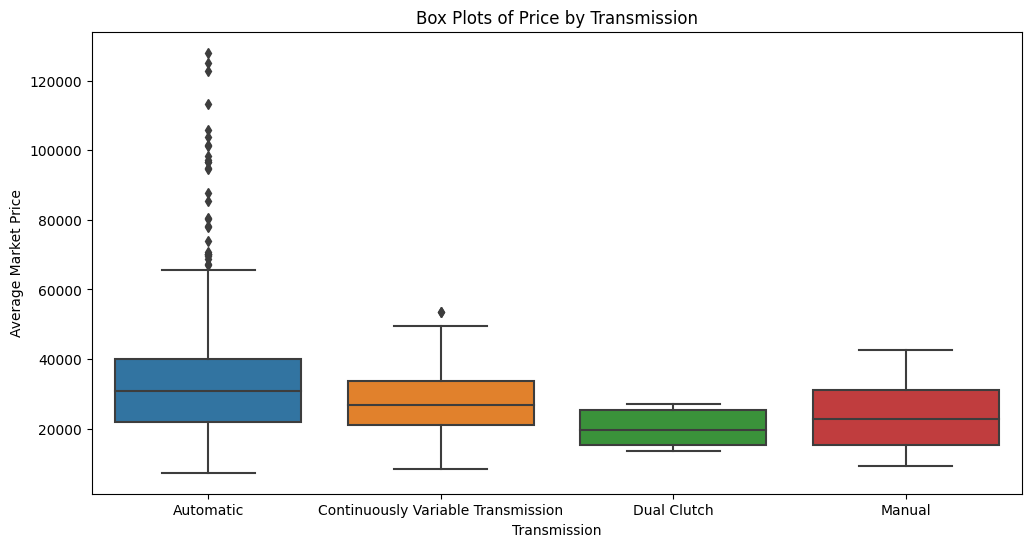

In [188]:
### Boxplots of Price by Transmission

plt.figure(figsize=(12, 6))

sns.boxplot(x = 'Transmission', y='Average Market Price', data= df_full )

plt.xlabel('Transmission')
plt.ylabel('Average Market Price')
plt.title('Box Plots of Price by Transmission')


Since automatic cars tend to be more reliables than CVT's and dual clutch cars, and easier to use than manuals, it makes sense that they are valued more in the used car market

Text(0.5, 1.0, 'Box Plots of Price by Doors')

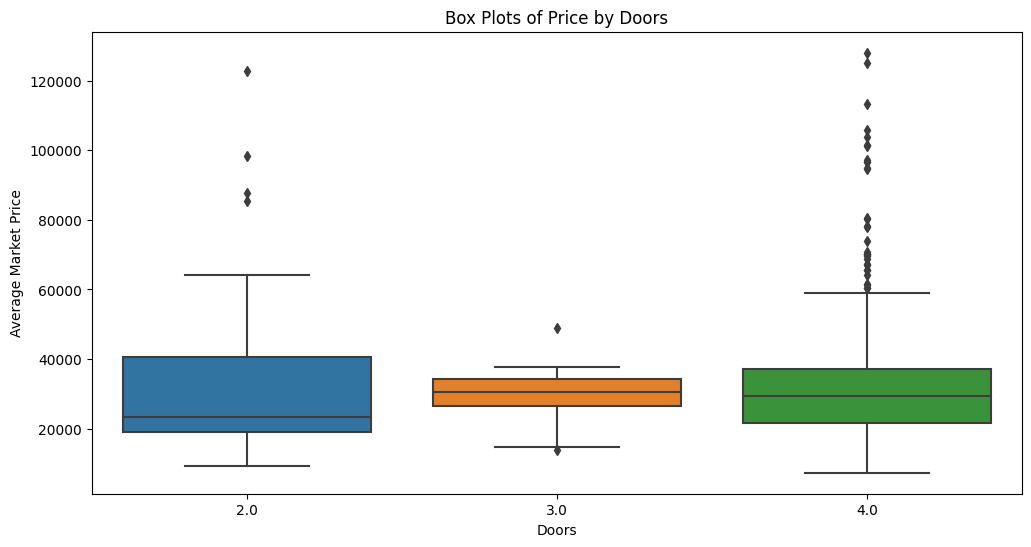

In [189]:
### Boxplots of Price by Doors

plt.figure(figsize=(12, 6))

sns.boxplot(x = 'Doors', y='Average Market Price', data= df_full )

plt.xlabel('Doors')
plt.ylabel('Average Market Price')
plt.title('Box Plots of Price by Doors')

Text(0.5, 1.0, 'Box Plots of Price by Condition')

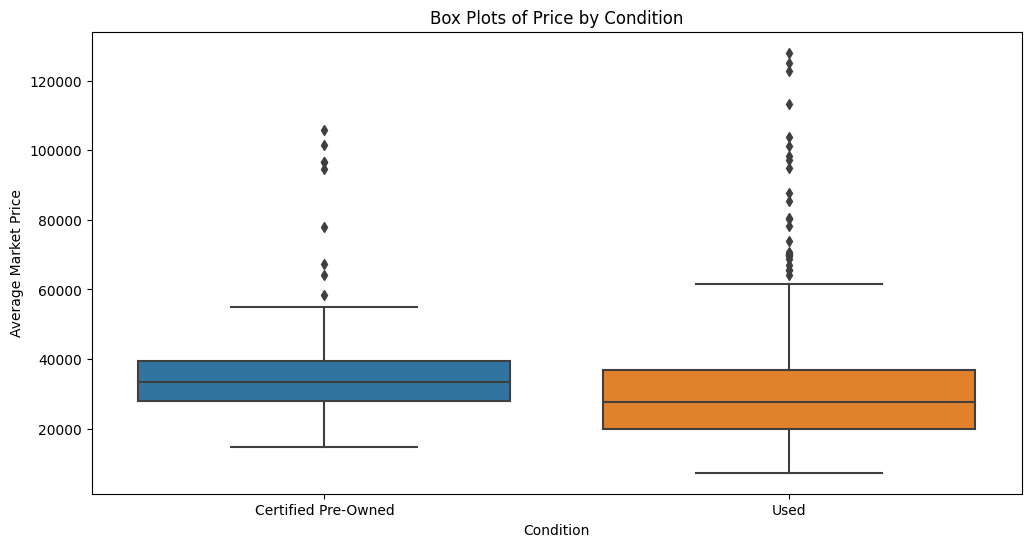

In [190]:
### Boxplots of Price by Condition

plt.figure(figsize=(12, 6))

sns.boxplot(x = 'Condition', y='Average Market Price', data= df_full )

plt.xlabel('Condition')
plt.ylabel('Average Market Price')
plt.title('Box Plots of Price by Condition')

## Feature Analysis

Now, we will remove outliers from the numeric columns

In [183]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 853 entries, 0 to 852
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Make                  853 non-null    object 
 1   Model                 853 non-null    object 
 2   Year                  853 non-null    int64  
 3   Body type             853 non-null    object 
 4   Exterior color        853 non-null    object 
 5   Mileage               853 non-null    int64  
 6   Condition             853 non-null    object 
 7   VIN                   853 non-null    object 
 8   Fuel type             853 non-null    object 
 9   Combined gas mileage  853 non-null    float64
 10  Fuel tank size(gal)   853 non-null    float64
 11  Transmission          853 non-null    object 
 12  Drivetrain            853 non-null    object 
 13  Engine Size(Liter)    853 non-null    float64
 14  Horsepower            853 non-null    float64
 15  Doors                 8

In [184]:
df_full['Name'] = df_full['Make'].str.cat(df_full['Model'], sep=' ')
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 853 entries, 0 to 852
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Make                  853 non-null    object 
 1   Model                 853 non-null    object 
 2   Year                  853 non-null    int64  
 3   Body type             853 non-null    object 
 4   Exterior color        853 non-null    object 
 5   Mileage               853 non-null    int64  
 6   Condition             853 non-null    object 
 7   VIN                   853 non-null    object 
 8   Fuel type             853 non-null    object 
 9   Combined gas mileage  853 non-null    float64
 10  Fuel tank size(gal)   853 non-null    float64
 11  Transmission          853 non-null    object 
 12  Drivetrain            853 non-null    object 
 13  Engine Size(Liter)    853 non-null    float64
 14  Horsepower            853 non-null    float64
 15  Doors                 8

In [185]:
df_full = df_full.drop(columns=['Make', 'Model'])
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 853 entries, 0 to 852
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Year                  853 non-null    int64  
 1   Body type             853 non-null    object 
 2   Exterior color        853 non-null    object 
 3   Mileage               853 non-null    int64  
 4   Condition             853 non-null    object 
 5   VIN                   853 non-null    object 
 6   Fuel type             853 non-null    object 
 7   Combined gas mileage  853 non-null    float64
 8   Fuel tank size(gal)   853 non-null    float64
 9   Transmission          853 non-null    object 
 10  Drivetrain            853 non-null    object 
 11  Engine Size(Liter)    853 non-null    float64
 12  Horsepower            853 non-null    float64
 13  Doors                 853 non-null    float64
 14  Front legroom(in)     853 non-null    float64
 15  Back legroom(in)      8

In [186]:
df_full = df_full.drop_duplicates(keep='last')
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 831 entries, 1 to 852
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Year                  831 non-null    int64  
 1   Body type             831 non-null    object 
 2   Exterior color        831 non-null    object 
 3   Mileage               831 non-null    int64  
 4   Condition             831 non-null    object 
 5   VIN                   831 non-null    object 
 6   Fuel type             831 non-null    object 
 7   Combined gas mileage  831 non-null    float64
 8   Fuel tank size(gal)   831 non-null    float64
 9   Transmission          831 non-null    object 
 10  Drivetrain            831 non-null    object 
 11  Engine Size(Liter)    831 non-null    float64
 12  Horsepower            831 non-null    float64
 13  Doors                 831 non-null    float64
 14  Front legroom(in)     831 non-null    float64
 15  Back legroom(in)      8

In [187]:
def detect_outliers(df,n,features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []

    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1

        # outlier step
        outlier_step = 1.5 * IQR

        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index

        # append the found outlier indices for col to the list of outlier indices
        outlier_indices.extend(outlier_list_col)

    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )

    return multiple_outliers

# detect outliers from Price, year & odo
Outliers_to_drop = detect_outliers(df_full,0,["Year","Mileage","Combined gas mileage","Fuel tank size(gal)","Engine Size(Liter)","Horsepower"])

df_full.loc[Outliers_to_drop] # Show the outliers rows
df_full = df_full.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)

In [188]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 691 entries, 0 to 690
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Year                  691 non-null    int64  
 1   Body type             691 non-null    object 
 2   Exterior color        691 non-null    object 
 3   Mileage               691 non-null    int64  
 4   Condition             691 non-null    object 
 5   VIN                   691 non-null    object 
 6   Fuel type             691 non-null    object 
 7   Combined gas mileage  691 non-null    float64
 8   Fuel tank size(gal)   691 non-null    float64
 9   Transmission          691 non-null    object 
 10  Drivetrain            691 non-null    object 
 11  Engine Size(Liter)    691 non-null    float64
 12  Horsepower            691 non-null    float64
 13  Doors                 691 non-null    float64
 14  Front legroom(in)     691 non-null    float64
 15  Back legroom(in)      6

In [189]:
### Columns that we won't use as features
df_full = df_full.drop(columns=['Front legroom(in)', 'Back legroom(in)',"Exterior color",'VIN'])

df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 691 entries, 0 to 690
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Year                  691 non-null    int64  
 1   Body type             691 non-null    object 
 2   Mileage               691 non-null    int64  
 3   Condition             691 non-null    object 
 4   Fuel type             691 non-null    object 
 5   Combined gas mileage  691 non-null    float64
 6   Fuel tank size(gal)   691 non-null    float64
 7   Transmission          691 non-null    object 
 8   Drivetrain            691 non-null    object 
 9   Engine Size(Liter)    691 non-null    float64
 10  Horsepower            691 non-null    float64
 11  Doors                 691 non-null    float64
 12  Price                 691 non-null    int64  
 13  Average Market Price  691 non-null    int64  
 14  Name                  691 non-null    object 
dtypes: float64(5), int64(4)

In [190]:
df_full.head()

,Year,Body type,Mileage,Condition,Fuel type,Combined gas mileage,Fuel tank size(gal),Transmission,Drivetrain,Engine Size(Liter),Horsepower,Doors,Price,Average Market Price,Name
0,2016,SUV / Crossover,48208,Used,Gasoline,29.0,15.0,Continuously Variable Transmission,Front-Wheel Drive,2.4,185.0,4.0,22995,22746,Honda CR-V
1,2020,SUV / Crossover,23269,Used,Gasoline,25.0,16.0,Automatic,Front-Wheel Drive,2.0,250.0,4.0,36888,36887,Lincoln Corsair
2,2015,Sedan,86950,Used,Gasoline,28.0,18.0,Automatic,Front-Wheel Drive,2.4,185.0,4.0,14799,14075,Hyundai Sonata
3,2018,Hatchback,30394,Used,Gasoline,32.0,13.0,Automatic,All-Wheel Drive,2.0,152.0,4.0,20995,22309,Subaru Impreza
4,2018,SUV / Crossover,54158,Used,Gasoline,24.0,15.0,Automatic,All-Wheel Drive,2.0,235.0,4.0,28311,30942,Lexus NX


In [191]:
df_reserve = df_full

In [192]:
##ONE-HOT ENCODING
df_full = pd.get_dummies(df_full, columns=['Name','Body type','Condition','Fuel type','Transmission','Drivetrain',"Doors"])
df_full.head()

,Year,Mileage,Combined gas mileage,Fuel tank size(gal),Engine Size(Liter),Horsepower,Price,Average Market Price,Name_Acura Integra,Name_Acura MDX,...,Transmission_Dual Clutch,Transmission_Manual,Drivetrain_4X2,Drivetrain_All-Wheel Drive,Drivetrain_Four-Wheel Drive,Drivetrain_Front-Wheel Drive,Drivetrain_Rear-Wheel Drive,Doors_2.0,Doors_3.0,Doors_4.0
0,2016,48208,29.0,15.0,2.4,185.0,22995,22746,0,0,...,0,0,0,0,0,1,0,0,0,1
1,2020,23269,25.0,16.0,2.0,250.0,36888,36887,0,0,...,0,0,0,0,0,1,0,0,0,1
2,2015,86950,28.0,18.0,2.4,185.0,14799,14075,0,0,...,0,0,0,0,0,1,0,0,0,1
3,2018,30394,32.0,13.0,2.0,152.0,20995,22309,0,0,...,0,0,0,1,0,0,0,0,0,1
4,2018,54158,24.0,15.0,2.0,235.0,28311,30942,0,0,...,0,0,0,1,0,0,0,0,0,1


In [193]:
### We will frop Price variable as we will use Average Market Price as our variable of interest
df_full = df_full.drop(columns=["Price"])

In [194]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 691 entries, 0 to 690
Columns: 253 entries, Year to Doors_4.0
dtypes: float64(4), int64(3), uint8(246)
memory usage: 203.9 KB


In [195]:
### Selecting x and y variables of our dataset
y = df_full.loc[:,['Average Market Price']]
x = df_full.drop(['Average Market Price'],axis=1)


In [196]:
### Dividing into train and test-splits
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 8933)

In [197]:
y_train

,Average Market Price
604,85419
2,14075
551,27672
405,20765
172,9472
...,...
214,9148
491,26625
512,27712
688,42508


## Model Building

### XGBoost Regression

In [229]:
x_train = x_train.filter(regex='^(?!.*(?:Doors|Drivetrain)).*$', axis=1)
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 552 entries, 604 to 229
Columns: 244 entries, Year to Transmission_Manual
dtypes: float64(6), uint8(238)
memory usage: 158.5 KB


In [230]:
x_test = x_test.filter(regex='^(?!.*(?:Doors|Drivetrain)).*$', axis=1)
x_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 139 entries, 138 to 680
Columns: 244 entries, Year to Transmission_Manual
dtypes: float64(6), uint8(238)
memory usage: 39.9 KB


In [231]:
### XGBoost Regressor ###
regressor = XGBRegressor(eval_metric= 'rmse')

param_grid = {
    'max_depth': [4, 5, 6],
    'n_estimators': [500, 600, 700],
    'learning_rate': [0.1, 0.25, 0.5, 0.75], 
    'alpha': [0.25, 0.5, 0.75],
    'lambda': [1e-5, 1e-2, 0.1] }

search_cv = RandomizedSearchCV(estimator=regressor, param_distributions=param_grid, cv=5, n_iter=50)
search_cv.fit(x_train, y_train['Average Market Price'])

RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric='rmse',
                                          feature_types=None, gamma=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rat...
                                          max_delta_step=None, max_depth=None,
                                          max_leaves=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None,
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None,
                                          random_state=None, ...),
                   n_iter=50,
                   param_distributions={'alpha': [0.25, 0.5, 0.75],
                                        'lambda': [1e-05, 0.01, 0.1],
                                        'learning_rate': [0.1, 0.25, 0.5, 0.75],
                                        'max_depth': [4, 5, 6],
                                        'n_estimators': [500, 600, 700]})

In [232]:
print("The best hyperparameters are ",search_cv.best_params_)

The best hyperparameters are  {'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.1, 'lambda': 0.1, 'alpha': 0.25}


In [233]:
best_regressor = search_cv.best_estimator_
best_regressor.fit(x_train, y_train['Average Market Price'])

XGBRegressor(alpha=0.25, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=0.1, learning_rate=0.1,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None, ...)

In [234]:
y_pred = best_regressor.predict(x_test)
mse = mean_squared_error(y_test['Average Market Price'], y_pred)
print("OS MSE for XGBoost Model: ", mse)
print("OS RMSE for XGBoost Model: ", mse**0.5)
r2 = r2_score(y_test, y_pred)
print("OOS R^2 for XGBoost Model: ", r2)

OS MSE for XGBoost Model:  35902623.709797956
OS RMSE for XGBoost Model:  5991.8798143652675
OOS R^2 for XGBoost Model:  0.7929784294452791


In [235]:
y_pred_is = best_regressor.predict(x_train)
mse_is = mean_squared_error(y_train['Average Market Price'], y_pred_is)
print("IS MSE for XGBoost Model: ", mse_is)
print("IS RMSE for XGBoost Model: ", mse_is**0.5)
r2_is = r2_score(y_train, y_pred_is)
print("IS R^2 for XGBoost Model: ", r2_is)

IS MSE for XGBoost Model:  1520772.750543299
IS RMSE for XGBoost Model:  1233.196152501012
IS R^2 for XGBoost Model:  0.9889768198116308


XGBoost model seems to overfit the data. It seems like OOS R^2 and MSE values suffer a lot compared to IS counterparts as a result of Overfitting.

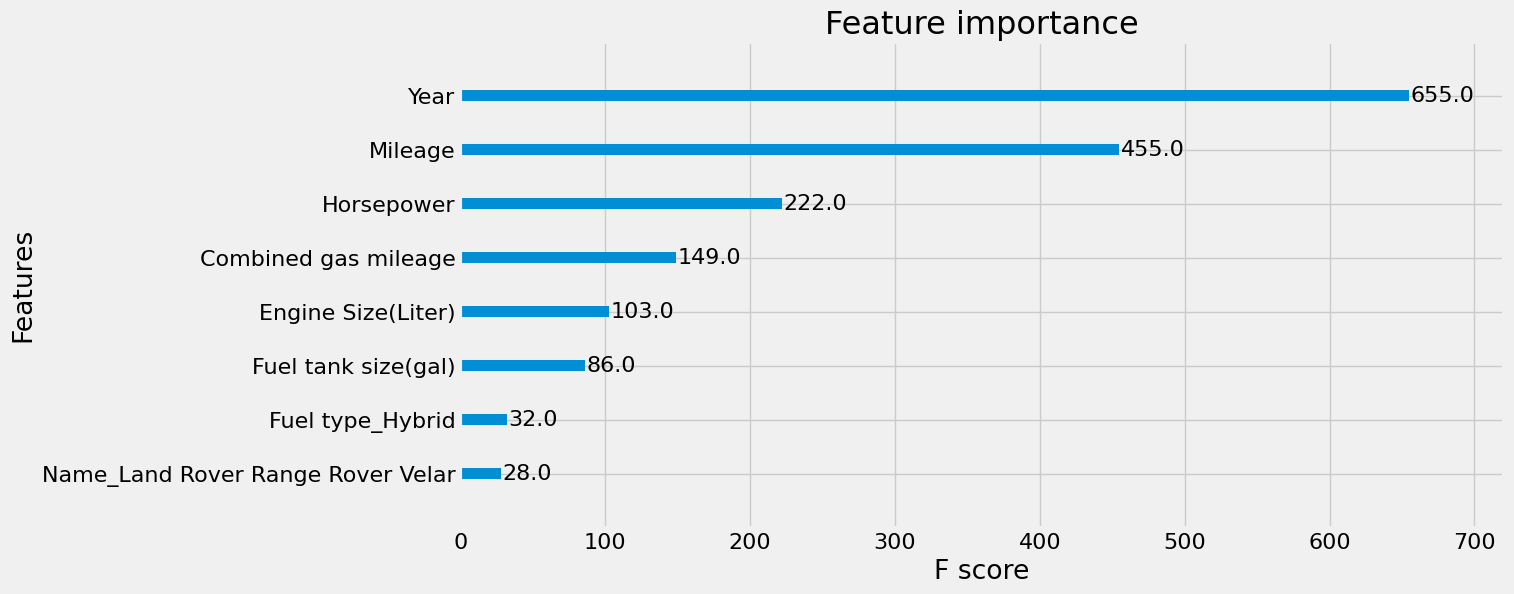

In [236]:
plt.style.use('fivethirtyeight')
plt.rcParams.update({'font.size': 16})

fig, ax = plt.subplots(figsize=(12,6))
plot_importance(best_regressor, max_num_features=8, ax=ax)
plt.show()

Feature Importance Graph for the XGBoost Model

### Lasso Regression

In [198]:
df_reserve = df_reserve.drop(columns='Price')
df_reserve.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 691 entries, 0 to 690
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Year                  691 non-null    int64  
 1   Body type             691 non-null    object 
 2   Mileage               691 non-null    int64  
 3   Condition             691 non-null    object 
 4   Fuel type             691 non-null    object 
 5   Combined gas mileage  691 non-null    float64
 6   Fuel tank size(gal)   691 non-null    float64
 7   Transmission          691 non-null    object 
 8   Drivetrain            691 non-null    object 
 9   Engine Size(Liter)    691 non-null    float64
 10  Horsepower            691 non-null    float64
 11  Doors                 691 non-null    float64
 12  Average Market Price  691 non-null    int64  
 13  Name                  691 non-null    object 
dtypes: float64(5), int64(3), object(6)
memory usage: 75.7+ KB


In [199]:
x_train_lasso = x_train
x_test_lasso = x_test

In [200]:
x_train_lasso.shape == x_train.shape

True

In [201]:
x_test_lasso.shape == x_test.shape

True

In [202]:
columns_to_standardize = ['Year', 'Mileage', 'Combined gas mileage', 'Fuel tank size(gal)', 'Engine Size(Liter)', 'Horsepower' ]

scaler = StandardScaler()
x_train_lasso[columns_to_standardize] = scaler.fit_transform(x_train_lasso[columns_to_standardize])
x_test_lasso[columns_to_standardize] = scaler.fit_transform(x_test_lasso[columns_to_standardize])


In [203]:
### Lasso Regression ###
regressor2 = Lasso()

param_grid2 = {'alpha': (np.logspace(-5, 5, 100))}

search_cv2 = RandomizedSearchCV(regressor2, param_grid2, cv=5, n_iter=50)
search_cv2.fit(x_train_lasso, y_train['Average Market Price'])

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.127e+09, tolerance: 5.638e+06
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.121e+09, tolerance: 6.076e+06
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations

RandomizedSearchCV(cv=5, estimator=Lasso(), n_iter=50,
                   param_distributions={'alpha': array([1.00000000e-05, 1.26185688e-05, 1.59228279e-05, 2.00923300e-05,
       2.53536449e-05, 3.19926714e-05, 4.03701726e-05, 5.09413801e-05,
       6.42807312e-05, 8.11130831e-05, 1.02353102e-04, 1.29154967e-04,
       1.62975083e-04, 2.05651231e-04, 2.59502421e-04, 3.27454916e-04,
       4.13201240e-04, 5.21400...
       4.75081016e+02, 5.99484250e+02, 7.56463328e+02, 9.54548457e+02,
       1.20450354e+03, 1.51991108e+03, 1.91791026e+03, 2.42012826e+03,
       3.05385551e+03, 3.85352859e+03, 4.86260158e+03, 6.13590727e+03,
       7.74263683e+03, 9.77009957e+03, 1.23284674e+04, 1.55567614e+04,
       1.96304065e+04, 2.47707636e+04, 3.12571585e+04, 3.94420606e+04,
       4.97702356e+04, 6.28029144e+04, 7.92482898e+04, 1.00000000e+05])})

In [204]:
best_regressor2 = search_cv2.best_estimator_
best_regressor2.fit(x_train_lasso, y_train['Average Market Price'])

y_pred2 = best_regressor2.predict(x_test_lasso)
mse2 = mean_squared_error(y_test['Average Market Price'], y_pred2)
print("MSE for Lasso Model: ", mse2)
print("RMSE for Lasso Model: ", mse2**0.5)
r2_2 = r2_score(y_test['Average Market Price'], y_pred2)
print("OOS R^2 for Lasso Model: ", r2_2)

MSE for Lasso Model:  39590027.27682226
RMSE for Lasso Model:  6292.060654254873
OOS R^2 for Lasso Model:  0.7717161371993192


In [205]:
y_pred_is2 = best_regressor2.predict(x_train)
mse_is2 = mean_squared_error(y_train['Average Market Price'], y_pred_is2)
print("IS MSE for Lasso Model: ", mse_is2)
print("IS RMSE for Lasso Model: ", mse_is2**0.5)
r2_is2 = r2_score(y_train, y_pred_is2)
print("IS R^2 for Lasso Model: ", r2_is2)

IS MSE for Lasso Model:  10747485.221016921
IS RMSE for Lasso Model:  3278.3357395204234
IS R^2 for Lasso Model:  0.9220978505034492


In [206]:
# Using np.abs() to make coefficients positive.  
lasso1_coef = np.abs(best_regressor2.coef_)

names = x_train_lasso.columns


df_lasso_coef = pd.DataFrame({"Columns_Name": names, "Coeff": lasso1_coef})

In [207]:
df_lasso_coef.sort_values(by='Coeff', ascending=False)


,Columns_Name,Coeff
208,Name_Toyota Sequoia,27625.442133
27,Name_BMW M4,25670.869394
164,Name_Mercedes-Benz GLE-Class,22910.690810
129,Name_Land Rover Range Rover Sport,19265.041284
130,Name_Land Rover Range Rover Velar,12947.663111
...,...,...
29,Name_BMW X3,0.000000
143,Name_Lincoln MKC,0.000000
144,Name_Lincoln MKZ Hybrid,0.000000
28,Name_BMW X2,0.000000


In [208]:
df_lasso_num = df_lasso_coef[df_lasso_coef['Columns_Name'].isin(columns_to_standardize)]
df_lasso_num.sort_values(by='Coeff', ascending=False)

,Columns_Name,Coeff
5,Horsepower,5796.015694
0,Year,3993.606859
1,Mileage,3138.290576
4,Engine Size(Liter),2024.219797
3,Fuel tank size(gal),1443.064071
2,Combined gas mileage,0.000000


we can clearly see that the model is overfitting probably due to the abundance of variables, we will try to drop some of the categorical variables and refitt the model

In [218]:
x_train_lasso.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 552 entries, 604 to 229
Columns: 252 entries, Year to Doors_4.0
dtypes: float64(6), uint8(246)
memory usage: 162.8 KB


In [219]:
x_train_lasso = x_train_lasso.filter(regex='^(?!.*(?:Doors|Drivetrain)).*$', axis=1)
x_train_lasso.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 552 entries, 604 to 229
Columns: 244 entries, Year to Transmission_Manual
dtypes: float64(6), uint8(238)
memory usage: 158.5 KB


In [220]:
x_test_lasso.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 139 entries, 138 to 680
Columns: 252 entries, Year to Doors_4.0
dtypes: float64(6), uint8(246)
memory usage: 41.0 KB


In [221]:
x_test_lasso = x_test_lasso.filter(regex='^(?!.*(?:Doors|Drivetrain)).*$', axis=1)
x_test_lasso.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 139 entries, 138 to 680
Columns: 244 entries, Year to Transmission_Manual
dtypes: float64(6), uint8(238)
memory usage: 39.9 KB


Refitting the Lasso Model after dropping some of the dummy variables

In [223]:
### Lasso Regression ###
regressor2 = Lasso()

param_grid2 = {'alpha': (np.logspace(-5, 5, 100))}

search_cv2 = RandomizedSearchCV(regressor2, param_grid2, cv=5, n_iter=50)
search_cv2.fit(x_train_lasso, y_train['Average Market Price'])

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.472e+09, tolerance: 5.638e+06
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.228e+09, tolerance: 6.076e+06
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations

RandomizedSearchCV(cv=5, estimator=Lasso(), n_iter=50,
                   param_distributions={'alpha': array([1.00000000e-05, 1.26185688e-05, 1.59228279e-05, 2.00923300e-05,
       2.53536449e-05, 3.19926714e-05, 4.03701726e-05, 5.09413801e-05,
       6.42807312e-05, 8.11130831e-05, 1.02353102e-04, 1.29154967e-04,
       1.62975083e-04, 2.05651231e-04, 2.59502421e-04, 3.27454916e-04,
       4.13201240e-04, 5.21400...
       4.75081016e+02, 5.99484250e+02, 7.56463328e+02, 9.54548457e+02,
       1.20450354e+03, 1.51991108e+03, 1.91791026e+03, 2.42012826e+03,
       3.05385551e+03, 3.85352859e+03, 4.86260158e+03, 6.13590727e+03,
       7.74263683e+03, 9.77009957e+03, 1.23284674e+04, 1.55567614e+04,
       1.96304065e+04, 2.47707636e+04, 3.12571585e+04, 3.94420606e+04,
       4.97702356e+04, 6.28029144e+04, 7.92482898e+04, 1.00000000e+05])})

In [225]:
best_regressor2 = search_cv2.best_estimator_
best_regressor2.fit(x_train_lasso, y_train['Average Market Price'])

y_pred2 = best_regressor2.predict(x_test_lasso)
mse2 = mean_squared_error(y_test['Average Market Price'], y_pred2)
print("MSE for Lasso Model: ", mse2)
print("RMSE for Lasso Model: ", mse2**0.5)
r2_2 = r2_score(y_test['Average Market Price'], y_pred2)
print("OOS R^2 for Lasso Model: ", r2_2)


y_pred_is2 = best_regressor2.predict(x_train_lasso)
mse_is2 = mean_squared_error(y_train['Average Market Price'], y_pred_is2)
print("IS MSE for Lasso Model: ", mse_is2)
print("IS RMSE for Lasso Model: ", mse_is2**0.5)
r2_is2 = r2_score(y_train, y_pred_is2)
print("IS R^2 for Lasso Model: ", r2_is2)

MSE for Lasso Model:  41084621.71795242
RMSE for Lasso Model:  6409.728677405341
OOS R^2 for Lasso Model:  0.7630980124893783
IS MSE for Lasso Model:  9327266.580856977
IS RMSE for Lasso Model:  3054.057396457535
IS R^2 for Lasso Model:  0.9323921735518934


### Ridge Regression

In [226]:
### Ridge Regression ###
regressor3 = Ridge()

param_grid2 = {'alpha': (np.logspace(-5, 5, 100))}

search_cv3 = RandomizedSearchCV(regressor3, param_grid2, cv=5, n_iter=50)
search_cv3.fit(x_train_lasso, y_train['Average Market Price'])


best_regressor3 = search_cv3.best_estimator_
best_regressor3.fit(x_train_lasso, y_train['Average Market Price'])

y_pred3 = best_regressor3.predict(x_test_lasso)
mse3 = mean_squared_error(y_test['Average Market Price'], y_pred3)
print("MSE for Ridge Model: ", mse3)
print("RMSE for Ridge Model: ", mse3**0.5)
r2_3 = r2_score(y_test['Average Market Price'], y_pred3)
print("OOS R^2 for Ridge Model: ", r2_3)


MSE for Ridge Model:  37612569.140094414
RMSE for Ridge Model:  6132.908701431516
OOS R^2 for Ridge Model:  0.7831185486910424


In [228]:
y_pred_is3 = best_regressor3.predict(x_train_lasso)
mse_is3 = mean_squared_error(y_train['Average Market Price'], y_pred_is3)
print("IS MSE for Ridge Model: ", mse_is3)
print("IS RMSE for Ridge Model: ", mse_is3**0.5)
r2_is3 = r2_score(y_train, y_pred_is3)
print("IS R^2 for Ridge Model: ", r2_is3)

IS MSE for Ridge Model:  10429192.043218445
IS RMSE for Ridge Model:  3229.4259618728597
IS R^2 for Ridge Model:  0.924404969072182


### Radnom Forest Regressor

In [ ]:
### Random Forest Regressor ###

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation,
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(x_train, y_train)

In [238]:
#Evaluating the model

best_params_rf = rf_random.best_params_
best_model_rf = rf_random.best_estimator_
y_pred_rf = best_model_rf.predict(x_test)
mse4 = mean_squared_error(y_test, y_pred_rf)
print("OOS MSE For the Random Forest Model: ", mse4)
print("OOS RMSE For the Random Forest Model: ", mse4**0.5)
r2_4 = r2_score(y_test, y_pred_rf)
print("OOS R^2 For the Random Forest Model: ", r2_4)

OOS MSE For the Random Forest Model:  34509042.144024074
OOS RMSE For the Random Forest Model:  5874.439730223136
OOS R^2 For the Random Forest Model:  0.8010140941023967


In [239]:
y_pred_rf_is = best_model_rf.predict(x_train)
mse_rf_is = mean_squared_error(y_train['Average Market Price'], y_pred_rf_is)
print("IS MSE for XGBoost Model: ", mse_rf_is)
print("IS RMSE for XGBoost Model: ", mse_rf_is**0.5)
r2_rf_is = r2_score(y_train, y_pred_rf_is)
print("IS R^2 for XGBoost Model: ", r2_rf_is)

IS MSE for XGBoost Model:  3876077.050033685
IS RMSE for XGBoost Model:  1968.7755204780674
IS R^2 for XGBoost Model:  0.9719046151167163


Overall, it seems like Random Forest and XGBoost models are performing the best although they are overfitting the dataset as well.

## Refitting the models for the last time, this time using only the make variable instead of Make + Model combination

### Feature Engineering 2

In [243]:
df_reserve = pd.merge(df_listing_ic, df_price_y, on='VIN', how='inner')

df_reserve.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 853 entries, 0 to 852
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Make                  853 non-null    object 
 1   Model                 853 non-null    object 
 2   Year                  853 non-null    int64  
 3   Body type             853 non-null    object 
 4   Exterior color        853 non-null    object 
 5   Mileage               853 non-null    int64  
 6   Condition             853 non-null    object 
 7   VIN                   853 non-null    object 
 8   Fuel type             853 non-null    object 
 9   Combined gas mileage  853 non-null    float64
 10  Fuel tank size(gal)   853 non-null    float64
 11  Transmission          853 non-null    object 
 12  Drivetrain            853 non-null    object 
 13  Engine Size(Liter)    853 non-null    float64
 14  Horsepower            853 non-null    float64
 15  Doors                 8

In [244]:
df_reserve = df_reserve.drop(columns=['Model', 'Exterior color' , 'Drivetrain', 'Doors', 'Front legroom(in)', 'Back legroom(in)', 'Price', 'VIN', "Fuel tank size(gal)"])
df_reserve.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 853 entries, 0 to 852
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Make                  853 non-null    object 
 1   Year                  853 non-null    int64  
 2   Body type             853 non-null    object 
 3   Mileage               853 non-null    int64  
 4   Condition             853 non-null    object 
 5   Fuel type             853 non-null    object 
 6   Combined gas mileage  853 non-null    float64
 7   Transmission          853 non-null    object 
 8   Engine Size(Liter)    853 non-null    float64
 9   Horsepower            853 non-null    float64
 10  Average Market Price  853 non-null    int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 80.0+ KB


In [245]:
df_reserve = df_reserve.drop_duplicates(keep='last')
df_reserve.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 830 entries, 1 to 852
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Make                  830 non-null    object 
 1   Year                  830 non-null    int64  
 2   Body type             830 non-null    object 
 3   Mileage               830 non-null    int64  
 4   Condition             830 non-null    object 
 5   Fuel type             830 non-null    object 
 6   Combined gas mileage  830 non-null    float64
 7   Transmission          830 non-null    object 
 8   Engine Size(Liter)    830 non-null    float64
 9   Horsepower            830 non-null    float64
 10  Average Market Price  830 non-null    int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 77.8+ KB


In [246]:
Outliers_to_drop = detect_outliers(df_reserve,0,["Year","Mileage","Combined gas mileage","Engine Size(Liter)","Horsepower"])

df_reserve.loc[Outliers_to_drop] # Show the outliers rows
df_reserve = df_reserve.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)

df_reserve.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 701 entries, 0 to 700
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Make                  701 non-null    object 
 1   Year                  701 non-null    int64  
 2   Body type             701 non-null    object 
 3   Mileage               701 non-null    int64  
 4   Condition             701 non-null    object 
 5   Fuel type             701 non-null    object 
 6   Combined gas mileage  701 non-null    float64
 7   Transmission          701 non-null    object 
 8   Engine Size(Liter)    701 non-null    float64
 9   Horsepower            701 non-null    float64
 10  Average Market Price  701 non-null    int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 60.4+ KB


In [247]:
df_reserve = pd.get_dummies(df_reserve, columns=['Make','Body type','Condition','Fuel type','Transmission'])
df_reserve.head()

,Year,Mileage,Combined gas mileage,Engine Size(Liter),Horsepower,Average Market Price,Make_Acura,Make_Audi,Make_BMW,Make_Buick,...,Condition_Certified Pre-Owned,Condition_Used,Fuel type_Diesel,Fuel type_Flex Fuel Vehicle,Fuel type_Gasoline,Fuel type_Hybrid,Transmission_Automatic,Transmission_Continuously Variable Transmission,Transmission_Dual Clutch,Transmission_Manual
0,2016,48208,29.0,2.4,185.0,22746,0,0,0,0,...,0,1,0,0,1,0,0,1,0,0
1,2020,23269,25.0,2.0,250.0,36887,0,0,0,0,...,0,1,0,0,1,0,1,0,0,0
2,2015,86950,28.0,2.4,185.0,14075,0,0,0,0,...,0,1,0,0,1,0,1,0,0,0
3,2018,30394,32.0,2.0,152.0,22309,0,0,0,0,...,0,1,0,0,1,0,1,0,0,0
4,2018,54158,24.0,2.0,235.0,30942,0,0,0,0,...,0,1,0,0,1,0,1,0,0,0


In [248]:
df_reserve.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 701 entries, 0 to 700
Data columns (total 57 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   Year                                             701 non-null    int64  
 1   Mileage                                          701 non-null    int64  
 2   Combined gas mileage                             701 non-null    float64
 3   Engine Size(Liter)                               701 non-null    float64
 4   Horsepower                                       701 non-null    float64
 5   Average Market Price                             701 non-null    int64  
 6   Make_Acura                                       701 non-null    uint8  
 7   Make_Audi                                        701 non-null    uint8  
 8   Make_BMW                                         701 non-null    uint8  
 9   Make_Buick                      

In [265]:
y = df_reserve.loc[:,['Average Market Price']]
x = df_reserve.drop(['Average Market Price'],axis=1)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 530)


In [266]:
x_train.columns

Index(['Year', 'Mileage', 'Combined gas mileage', 'Engine Size(Liter)',
       'Horsepower', 'Make_Acura', 'Make_Audi', 'Make_BMW', 'Make_Buick',
       'Make_Cadillac', 'Make_Chevrolet', 'Make_Chrysler', 'Make_Dodge',
       'Make_Ford', 'Make_GMC', 'Make_Genesis', 'Make_Honda', 'Make_Hyundai',
       'Make_INFINITI', 'Make_Jaguar', 'Make_Jeep', 'Make_Kia',
       'Make_Land Rover', 'Make_Lexus', 'Make_Lincoln', 'Make_MINI',
       'Make_Maserati', 'Make_Mazda', 'Make_Mercedes-Benz', 'Make_Mitsubishi',
       'Make_Nissan', 'Make_RAM', 'Make_Scion', 'Make_Subaru', 'Make_Toyota',
       'Make_Volkswagen', 'Make_Volvo', 'Body type_Convertible',
       'Body type_Coupe', 'Body type_Hatchback', 'Body type_Minivan',
       'Body type_Pickup Truck', 'Body type_SUV / Crossover',
       'Body type_Sedan', 'Body type_Van', 'Body type_Wagon',
       'Condition_Certified Pre-Owned', 'Condition_Used', 'Fuel type_Diesel',
       'Fuel type_Flex Fuel Vehicle', 'Fuel type_Gasoline', 'Fuel type_Hybri

### Lasso Regression 2

In [267]:
#### Lasso Regression ####

x_train_lasso = x_train
x_test_lasso = x_test

columns_to_standardize = ['Year', 'Mileage', 'Combined gas mileage', 'Engine Size(Liter)', 'Horsepower' ]

scaler = StandardScaler()
x_train_lasso[columns_to_standardize] = scaler.fit_transform(x_train_lasso[columns_to_standardize])
x_test_lasso[columns_to_standardize] = scaler.fit_transform(x_test_lasso[columns_to_standardize])

In [270]:
### Lasso Regression ###
regressor2 = Lasso()

param_grid2 = {'alpha': (np.logspace(-5, 5, 100))}

search_cv2 = RandomizedSearchCV(regressor2, param_grid2, cv=5, n_iter=50)
search_cv2.fit(x_train_lasso, y_train['Average Market Price'])

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.180e+08, tolerance: 6.503e+06
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.612e+09, tolerance: 7.024e+06
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations

RandomizedSearchCV(cv=5, estimator=Lasso(), n_iter=50,
                   param_distributions={'alpha': array([1.00000000e-05, 1.26185688e-05, 1.59228279e-05, 2.00923300e-05,
       2.53536449e-05, 3.19926714e-05, 4.03701726e-05, 5.09413801e-05,
       6.42807312e-05, 8.11130831e-05, 1.02353102e-04, 1.29154967e-04,
       1.62975083e-04, 2.05651231e-04, 2.59502421e-04, 3.27454916e-04,
       4.13201240e-04, 5.21400...
       4.75081016e+02, 5.99484250e+02, 7.56463328e+02, 9.54548457e+02,
       1.20450354e+03, 1.51991108e+03, 1.91791026e+03, 2.42012826e+03,
       3.05385551e+03, 3.85352859e+03, 4.86260158e+03, 6.13590727e+03,
       7.74263683e+03, 9.77009957e+03, 1.23284674e+04, 1.55567614e+04,
       1.96304065e+04, 2.47707636e+04, 3.12571585e+04, 3.94420606e+04,
       4.97702356e+04, 6.28029144e+04, 7.92482898e+04, 1.00000000e+05])})

In [271]:
best_regressor2 = search_cv2.best_estimator_
best_regressor2.fit(x_train_lasso, y_train['Average Market Price'])

y_pred2 = best_regressor2.predict(x_test_lasso)
mse2 = mean_squared_error(y_test['Average Market Price'], y_pred2)
print("MSE for Lasso Model: ", mse2)
print("RMSE for Lasso Model: ", mse2**0.5)
r2_2 = r2_score(y_test['Average Market Price'], y_pred2)
print("OOS R^2 for Lasso Model: ", r2_2)


y_pred_is2 = best_regressor2.predict(x_train_lasso)
mse_is2 = mean_squared_error(y_train['Average Market Price'], y_pred_is2)
print("IS MSE for Lasso Model: ", mse_is2)
print("IS RMSE for Lasso Model: ", mse_is2**0.5)
r2_is2 = r2_score(y_train, y_pred_is2)
print("IS R^2 for Lasso Model: ", r2_is2)

MSE for Lasso Model:  30672149.068181932
RMSE for Lasso Model:  5538.244222511493
OOS R^2 for Lasso Model:  0.7385694748272393
IS MSE for Lasso Model:  30999404.850784615
IS RMSE for Lasso Model:  5567.71091659621
IS R^2 for Lasso Model:  0.7997996171044222


### Ridge Regression 2 ###

In [272]:
### Ridge Regression ###
regressor3 = Ridge()

param_grid2 = {'alpha': (np.logspace(-5, 5, 100))}

search_cv3 = RandomizedSearchCV(regressor3, param_grid2, cv=5, n_iter=50)
search_cv3.fit(x_train_lasso, y_train['Average Market Price'])


best_regressor3 = search_cv3.best_estimator_
best_regressor3.fit(x_train_lasso, y_train['Average Market Price'])

y_pred3 = best_regressor3.predict(x_test_lasso)
mse3 = mean_squared_error(y_test['Average Market Price'], y_pred3)
print("MSE for Ridge Model: ", mse3)
print("RMSE for Ridge Model: ", mse3**0.5)
r2_3 = r2_score(y_test['Average Market Price'], y_pred3)
print("OOS R^2 for Ridge Model: ", r2_3)




MSE for Ridge Model:  28213167.895768538
RMSE for Ridge Model:  5311.606903355005
OOS R^2 for Ridge Model:  0.759528317256733


In [273]:
y_pred_is3 = best_regressor3.predict(x_train_lasso)
mse_is3 = mean_squared_error(y_train['Average Market Price'], y_pred_is3)
print("IS MSE for Ridge Model: ", mse_is3)
print("IS RMSE for Ridge Model: ", mse_is3**0.5)
r2_is3 = r2_score(y_train, y_pred_is3)
print("IS R^2 for Ridge Model: ", r2_is3)

IS MSE for Ridge Model:  30195902.0083039
IS RMSE for Ridge Model:  5495.079799994164
IS R^2 for Ridge Model:  0.8049887998483047


### XGBoost 2 ###

In [274]:
### XGBoost 2 ###
### XGBoost Regressor ###
regressor = XGBRegressor(eval_metric= 'rmse')

param_grid = {
    'max_depth': [4, 5, 6],
    'n_estimators': [500, 600, 700],
    'learning_rate': [0.1, 0.25, 0.5, 0.75], 
    'alpha': [0.25, 0.5, 0.75],
    'lambda': [1e-5, 1e-2, 0.1] }

search_cv = RandomizedSearchCV(estimator=regressor, param_distributions=param_grid, cv=5, n_iter=50)
search_cv.fit(x_train, y_train['Average Market Price'])

RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric='rmse',
                                          feature_types=None, gamma=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rat...
                                          max_delta_step=None, max_depth=None,
                                          max_leaves=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None,
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None,
                                          random_state=None, ...),
                   n_iter=50,
                   param_distributions={'alpha': [0.25, 0.5, 0.75],
                                        'lambda': [1e-05, 0.01, 0.1],
                                        'learning_rate': [0.1, 0.25, 0.5, 0.75],
                                        'max_depth': [4, 5, 6],
                                        'n_estimators': [500, 600, 700]})

In [275]:
best_regressor = search_cv.best_estimator_
best_regressor.fit(x_train, y_train['Average Market Price'])

y_pred = best_regressor.predict(x_test)
mse = mean_squared_error(y_test['Average Market Price'], y_pred)
print("OOS MSE for XGBoost Model: ", mse)
print("OOS RMSE for XGBoost Model: ", mse**0.5)
r2 = r2_score(y_test, y_pred)
print("OOS R^2 for XGBoost Model: ", r2)


y_pred_is = best_regressor.predict(x_train)
mse_is = mean_squared_error(y_train['Average Market Price'], y_pred_is)
print("IS MSE for XGBoost Model: ", mse_is)
print("IS RMSE for XGBoost Model: ", mse_is**0.5)
r2_is = r2_score(y_train, y_pred_is)
print("IS R^2 for XGBoost Model: ", r2_is)

OOS MSE for XGBoost Model:  21396918.393581614
OOS RMSE for XGBoost Model:  4625.680316837904
OOS R^2 for XGBoost Model:  0.8176258337725824
IS MSE for XGBoost Model:  172519.3939515676
IS RMSE for XGBoost Model:  415.35454006374795
IS R^2 for XGBoost Model:  0.9988858351025683


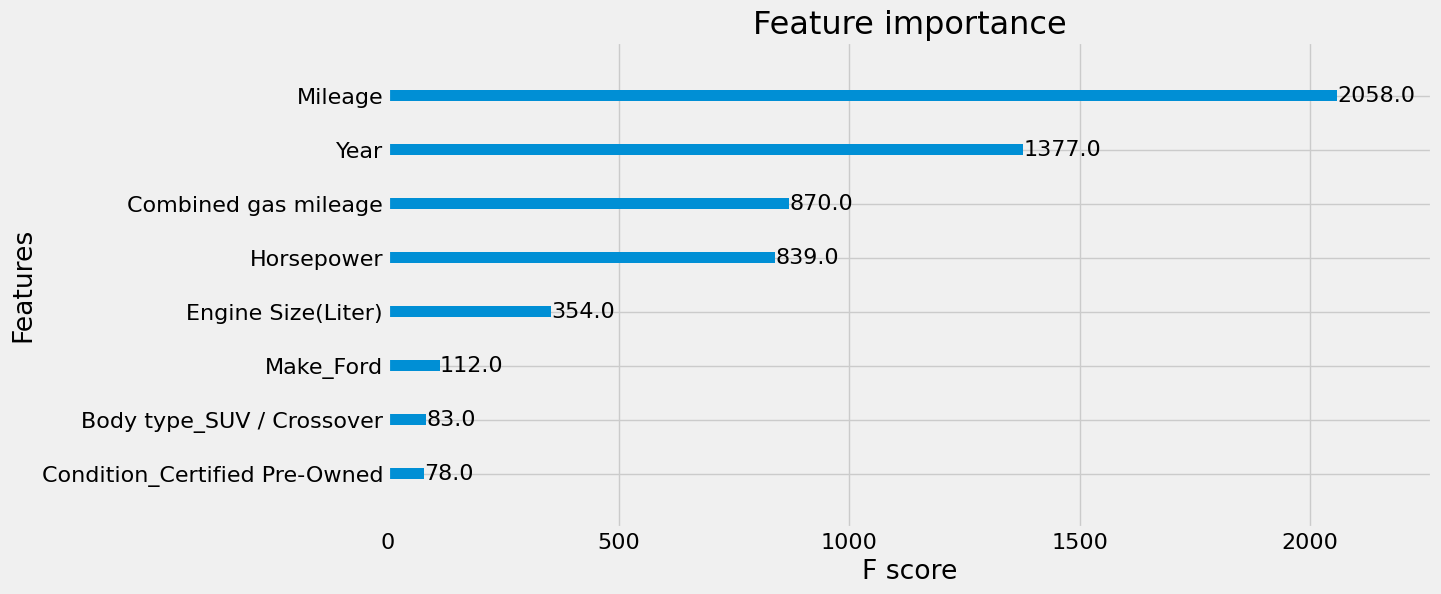

In [276]:
plt.style.use('fivethirtyeight')
plt.rcParams.update({'font.size': 16})

fig, ax = plt.subplots(figsize=(12,6))
plot_importance(best_regressor, max_num_features=8, ax=ax)
plt.show()

### Random Forest 2


In [277]:
### Random Forest ###

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation,
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(x_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Pytho

[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   1.8s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   1.8s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   1.8s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1200; total time=   3.6s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=2000; total time=   8.2s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1200; total time=   4.1s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=2000; total time=   8.1s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=2000; total time=   8.2s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit

[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1200; total time=   3.8s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1600; total time=   5.8s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=2000; total time=   9.7s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=2000; total time=   9.9s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=2000; total time=  10.0s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=800; total time=   2.5s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=800; total time=   2.6s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1600; total time=   6.4s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=800; total time=   2.8s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1600; total time=   6.5s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1000; total time=   3.5s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1000; total time=   3.3s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=600; total time=   2.1s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=600; total time=   2.8s
[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1000; total time=   3.9s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit

[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=600; total time=   4.9s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time=  12.2s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time=  11.6s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time=  11.7s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit

[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=400; total time=   3.3s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1800; total time=  12.9s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=400; total time=   2.4s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=400; total time=   3.0s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=800; total time=   3.8s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=800; total time=   3.1s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1800; total time=  12.2s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1800; total time=  12.2s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=800; total time=   3.4s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=2000; total time=   7.0s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1600; total time=   5.5s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=2000; total time=   6.9s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=2000; total time=   6.9s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=800; total time=   3.2s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=800; total time=   3.2s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1600; total time=   6.3s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1600; total time=   6.2s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=800; total time=   3.0s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit

[CV] END bootstrap=False, max_depth=70, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=600; total time=   3.4s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=70, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=600; total time=   4.8s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1800; total time=  10.9s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit

[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1800; total time=  10.8s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1800; total time=  11.1s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=70, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=600; total time=   4.0s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time=   5.9s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time=   7.8s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time=   8.4s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=600; total time=   6.2s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=1800; total time=  16.1s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=1800; total time=  15.8s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=600; total time=   5.0s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=1800; total time=  14.7s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=600; total time=   5.0s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1800; total time=   7.5s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1800; total time=   7.5s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1800; total time=   7.6s
[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1600; total time=   6.9s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1600; total time=   7.0s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1600; total time=   7.1s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=1400; total time=   7.1s
[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=1400; total time=   7.1s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit

[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=1400; total time=   7.0s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=   5.7s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1800; total time=  12.7s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1800; total time=  12.5s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1800; total time=  12.8s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=400; total time=   2.3s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=400; total time=   2.3s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=   7.1s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=400; total time=   2.3s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit

[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=   7.0s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1000; total time=   4.8s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1000; total time=   4.8s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1400; total time=  12.5s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1400; total time=  12.7s
[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1400; total time=  12.9s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit

[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1000; total time=   6.9s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1200; total time=   5.9s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=2000; total time=  13.7s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=2000; total time=  13.8s
[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=2000; total time=  13.6s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1200; total time=   6.5s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1200; total time=   6.6s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=1200; total time=   5.2s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=1200; total time=   5.2s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=1200; total time=   5.0s
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=800; total time=   3.5s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=800; total time=   3.5s
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=800; total time=   3.5s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=800; total time=   3.6s
[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=800; total time=   3.6s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=800; total time=   3.6s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=800; total time=   4.1s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=800; total time=   4.2s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=800; total time=   4.2s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=800; total time=   3.2s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1800; total time=   9.3s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1800; total time=   9.4s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=800; total time=   3.8s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=800; total time=   3.6s
[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1800; total time=   9.5s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors a

[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1200; total time=   6.4s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1200; total time=   6.5s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1200; total time=   6.4s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=800; total time=   7.1s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=800; total time=   7.3s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=800; total time=   7.4s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=800; total time=   6.1s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=800; total time=   6.3s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1000; total time=   5.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=800; total time=   6.1s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit

[CV] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1000; total time=   5.4s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   1.6s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   1.5s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1000; total time=   5.6s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   1.7s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=600; total time=   3.4s
[CV] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=600; total time=   3.4s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=600; total time=   3.4s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=800; total time=   4.6s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=400; total time=   2.5s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=800; total time=   4.4s
[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=400; total time=   2.0s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit

[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=800; total time=   5.0s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=400; total time=   2.4s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   2.0s
[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   2.0s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   1.7s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time=   5.7s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time=   5.6s
[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time=   5.7s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit

[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=400; total time=   1.8s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=400; total time=   1.9s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=400; total time=   1.8s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=  15.1s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=   4.7s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=  15.1s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=   4.9s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=   4.9s
[CV] END bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=  15.3s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors a

[CV] END bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   3.0s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   3.1s
[CV] END bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   2.8s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit

[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=2000; total time=  11.4s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1800; total time=  15.1s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1800; total time=  15.5s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1800; total time=  15.0s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit

[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=1000; total time=   5.8s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=1000; total time=   5.8s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit

[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=2000; total time=  12.6s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=2000; total time=  13.0s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1000; total time=   6.9s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=1000; total time=   6.9s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1000; total time=   6.9s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1000; total time=   6.9s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1400; total time=   6.0s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1400; total time=   6.5s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=600; total time=   3.3s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=600; total time=   3.0s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=600; total time=   2.7s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit

[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1400; total time=   6.9s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=1600; total time=  11.0s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=1600; total time=  11.1s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=1600; total time=  11.2s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit

[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1800; total time=  12.5s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1400; total time=  10.8s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1800; total time=  12.3s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1800; total time=  12.3s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1400; total time=  10.9s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1400; total time=   7.5s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1400; total time=   7.6s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.2s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1400; total time=   7.9s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.9s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=400; total time=   2.6s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=400; total time=   2.5s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit

[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=400; total time=   2.3s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1400; total time=  13.5s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit

[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=1000; total time=   5.8s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=1000; total time=   6.0s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit

[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=1000; total time=   5.9s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=1200; total time=   7.8s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=1200; total time=   7.7s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=1200; total time=   8.2s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1600; total time=   8.4s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1600; total time=   8.1s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1600; total time=   8.4s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=1600; total time=  10.8s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=1600; total time=  10.7s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=1600; total time=  11.3s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1800; total time=  11.6s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1800; total time=  11.8s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1800; total time=  11.8s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1400; total time=  10.0s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=   4.3s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=   4.4s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1400; total time=  11.1s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=   4.9s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1400; total time=  11.5s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1400; total time=   5.0s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=2000; total time=  13.5s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=2000; total time=  13.8s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1400; total time=   6.3s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=2000; total time=  14.1s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=800; total time=   3.5s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1400; total time=   6.6s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=800; total time=   3.7s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=800; total time=   4.0s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   3.3s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   3.2s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1800; total time=  10.1s
[CV] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1800; total time=   9.8s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit

[CV] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1800; total time=  10.4s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   3.9s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=400; total time=   2.2s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=400; total time=   2.0s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=400; total time=   1.8s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=1600; total time=  13.5s
[CV] END bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=1600; total time=  13.5s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=1600; total time=  13.7s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1600; total time=   8.7s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1600; total time=   8.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1600; total time=   8.9s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=2000; total time=  10.8s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1000; total time=   5.0s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=2000; total time=  10.6s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   1.7s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1000; total time=   6.3s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   1.7s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1000; total time=   6.5s
[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=2000; total time=  11.9s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit

[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=600; total time=   4.0s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=600; total time=   3.8s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=2000; total time=  13.5s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=2000; total time=  14.0s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=600; total time=   6.0s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=2000; total time=  15.6s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1000; total time=  11.9s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=800; total time=   8.8s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1000; total time=  11.7s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1000; total time=  11.4s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=800; total time=   6.0s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=800; total time=   6.2s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=800; total time=   9.5s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=800; total time=   9.6s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=600; total time=   4.4s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=800; total time=   5.6s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=600; total time=   3.7s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=600; total time=   3.6s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   2.2s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   1.8s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   1.9s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=800; total time=   6.4s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1600; total time=  11.9s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1600; total time=  12.7s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1600; total time=  13.3s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=800; total time=   7.0s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=800; total time=   5.9s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1000; total time=   6.1s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1000; total time=   6.0s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1000; total time=   5.9s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=600; total time=   3.4s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=600; total time=   3.4s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=600; total time=   3.4s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=800; total time=   3.9s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=2000; total time=   8.2s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=2000; total time=   8.7s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors a

[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=2000; total time=   9.8s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=800; total time=   6.0s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=600; total time=   6.1s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=800; total time=   6.6s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=600; total time=   5.4s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=600; total time=   3.7s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=600; total time=   3.6s
[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=600; total time=   6.1s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit

[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=600; total time=   3.3s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=400; total time=   3.5s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=400; total time=   4.2s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=400; total time=   4.4s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   1.8s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   2.4s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   2.1s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time=  14.0s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time=  14.1s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time=  14.4s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=  15.9s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=  13.7s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=  13.9s
[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=2000; total time=  16.4s
[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=2000; total time=  15.5s
[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=2000; total time=  14.5s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_search.py:910: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [278]:
#Evaluating the model

best_params_rf = rf_random.best_params_
best_model_rf = rf_random.best_estimator_
y_pred_rf = best_model_rf.predict(x_test)
mse4 = mean_squared_error(y_test, y_pred_rf)
print("OOS MSE For the Random Forest Model: ", mse4)
print("OOS RMSE For the Random Forest Model: ", mse4**0.5)
r2_4 = r2_score(y_test, y_pred_rf)
print("OOS R^2 For the Random Forest Model: ", r2_4)

OOS MSE For the Random Forest Model:  22070508.725971796
OOS RMSE For the Random Forest Model:  4697.926002607086
OOS R^2 For the Random Forest Model:  0.8118845642594287


In [279]:
y_pred_rf_is = best_model_rf.predict(x_train)
mse_rf_is = mean_squared_error(y_train['Average Market Price'], y_pred_rf_is)
print("IS MSE for XGBoost Model: ", mse_rf_is)
print("IS RMSE for XGBoost Model: ", mse_rf_is**0.5)
r2_rf_is = r2_score(y_train, y_pred_rf_is)
print("IS R^2 for XGBoost Model: ", r2_rf_is)

IS MSE for XGBoost Model:  4411587.703646039
IS RMSE for XGBoost Model:  2100.3779906593095
IS R^2 for XGBoost Model:  0.9715090805227183


Overall, we can clearly see that even after feature engineering, XGBoost and Random Forest models overfit the dataset very heavily. Although they yield relatively better OOS R^2 and RMSE values, it is way worse than what they get In-Sample which is a clear sign of overfitting. I personally would go for Lasso or Ridge regression models for this problem because althogh they do get a bit worse R^2 and RMSE values out of sample, they do not overfit the dataset at all and they would do a better job predicting the price on the never-seen before data observations